In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from calendar import monthrange
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

commodities = ['Maize', 'Wheat', 'Oats', 'Soybeans']
DATA_PATH = '/kaggle/input/processed-data' # Remove the /kaggle/input prefix for reproducing the results
Y_COLUMN = 'Sep'


## Let's look at the dataset and see if it is plausible that it has some seasonality.

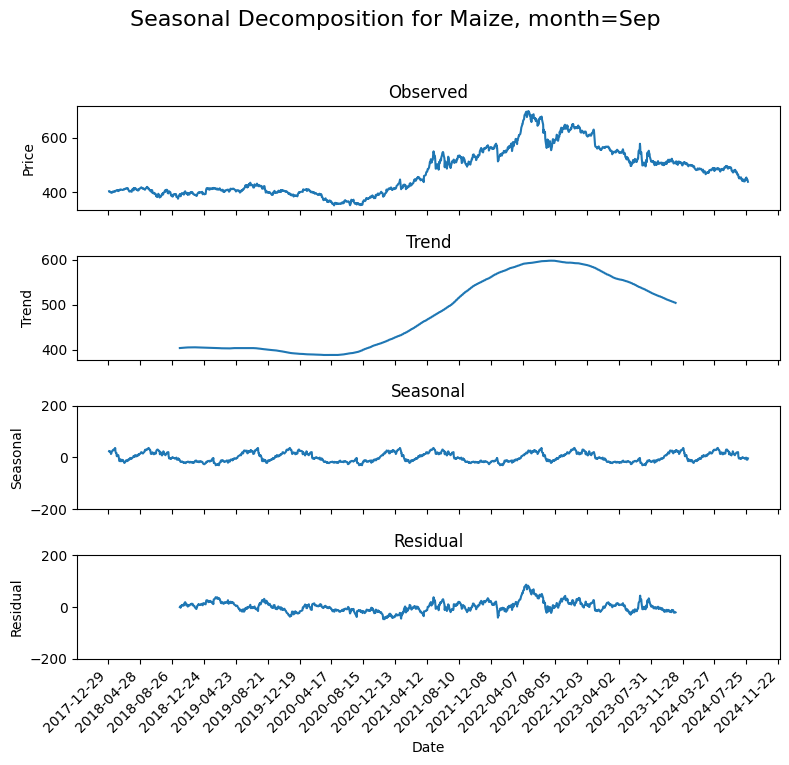

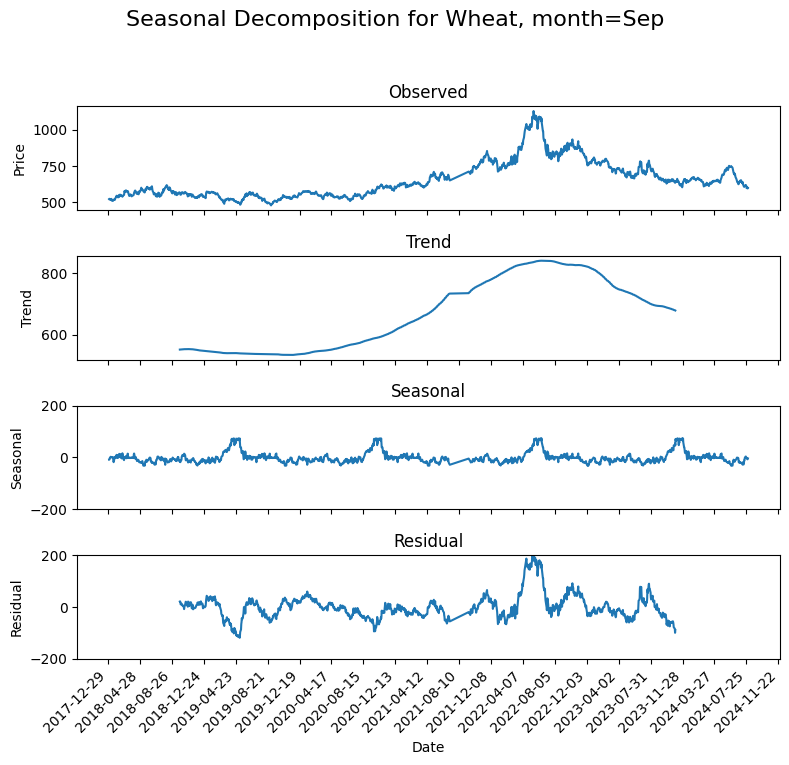

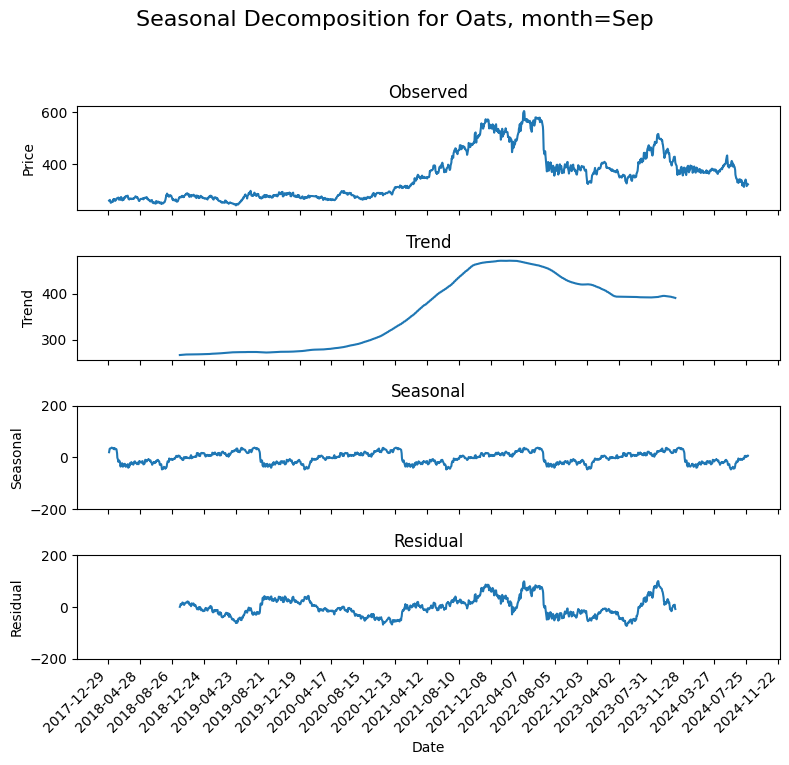

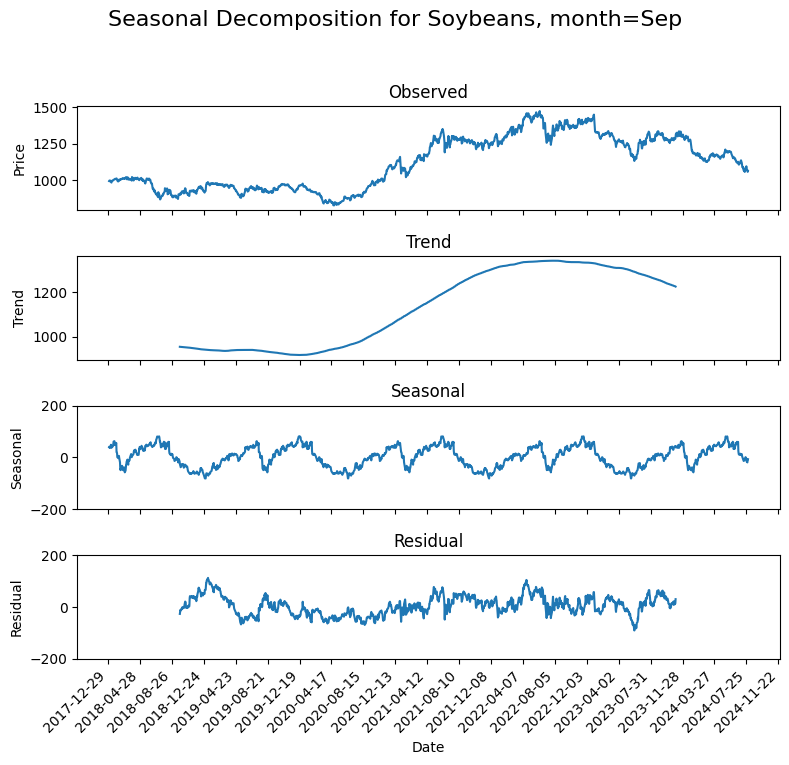

In [2]:
commodities_datasets = []
for commodity in commodities:
    dataset = pd.read_csv(f'{DATA_PATH}/full_{commodity}.csv')
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset = dataset[['Date', Y_COLUMN]]
    commodities_datasets.append(dataset)

    fig, axs = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

    # Perform seasonal decomposition
    SES = seasonal_decompose(dataset.set_index('Date')[Y_COLUMN], period=365, model='additive')
    
    # Plot each component
    axs[0].plot(dataset['Date'], SES.observed)
    axs[1].plot(dataset['Date'], SES.trend)
    axs[2].plot(dataset['Date'], SES.seasonal)
    axs[3].plot(dataset['Date'], SES.resid)

    # Set titles and labels
    axs[0].set_title('Observed')
    axs[0].set_ylabel('Price')
    axs[1].set_title('Trend')
    axs[1].set_ylabel('Trend')
    axs[2].set_title('Seasonal')
    axs[2].set_ylabel('Seasonal')
    axs[3].set_title('Residual')
    axs[3].set_ylabel('Residual')
    axs[3].set_xlabel('Date')

    # Set y-axis limits for seasonal and residuals
    axs[2].set_ylim(-200, 200)
    axs[3].set_ylim(-200, 200)

    # Set x-axis ticks to 30-day intervals
    axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=120))
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axs[1].xaxis.set_major_locator(mdates.DayLocator(interval=120))
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axs[2].xaxis.set_major_locator(mdates.DayLocator(interval=120))
    axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axs[3].xaxis.set_major_locator(mdates.DayLocator(interval=120))
    axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Rotate x-axis labels for better readability
    plt.setp(axs[3].xaxis.get_majorticklabels(), rotation=45, ha='right')

    plt.suptitle(f"Seasonal Decomposition for {commodity}, month={Y_COLUMN}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print()


In the graphs above, we observe the time series for the September futures contracts of the four commodities examined in this research. For each date, the September contract corresponds to the upcoming September (e.g., a date in 2019 is associated with the September 2020 contract). We have decomposed each time series into components: Trend, Seasonal Effect, and Residuals (noise). The original time series is labeled as "Observed."

-------

In this notebook we aim to investigate the approach of using statistical models such as ARIMA (AutoRegressive Integrated Moving Average) to predict the prices of September futures contracts. As illustrated in the graphs, it seems plausible that the September contracts for the four commodities exhibit a seasonal effect (we checked for yearly seasonality by setting the period to 365, as the dataset is recorded day by day). Therefore, we will explore SARIMA models, which account for seasonality in the time series.

We will apply SARIMA models to each commodity separately, splitting the data into 80% training and 20% testing sets, with the test set consisting of the most recent 20% of the data. We will fit the model to the training data, selecting SARIMA's hyperparameters based on the training set, and then evaluate the model's performance on the test set.

In [3]:
train_datasets = []
test_datasets = []
for i in range(len(commodities_datasets)):
    split_index = int(len(commodities_datasets[i]) * 0.8)
    train_df = commodities_datasets[i].iloc[:split_index]
    test_df = commodities_datasets[i].iloc[split_index:]
    train_datasets.append(train_df)
    test_datasets.append(test_df)
    assert len(commodities_datasets[i]) == len(train_df) + len(test_df)

At the start of this notebook, we examined whether it is plausible that the datasets exhibit a seasonal effect on a yearly basis. Specifically, if we denote the original series by $X_t$, we would like to consider: 
$Y_t \stackrel{\mathrm{def}}{=} X_t - X_{t-365} $, as the dataset is recorded daily. We aim to analyze the differenced series and check whether it has the properties necessary for further investigation using SARIMA models. These properties include stationarity— whether does the expectation of the series remain constant over time (i.e., all observations, on average, fluctuate around the same horizontal line, w.l.o.g the line y=0)—and homoscedasticity, which assumes that the variance around this horizontal line is constant and does not depend on time.

If we look at the $Y_t$ series, i.e. account for only the yearly seasonality effect for each commodity:

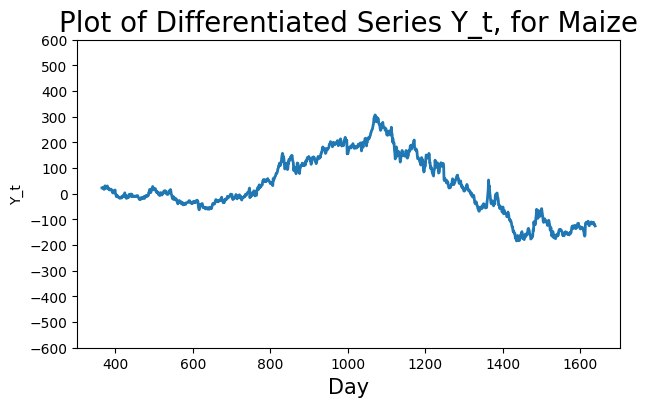

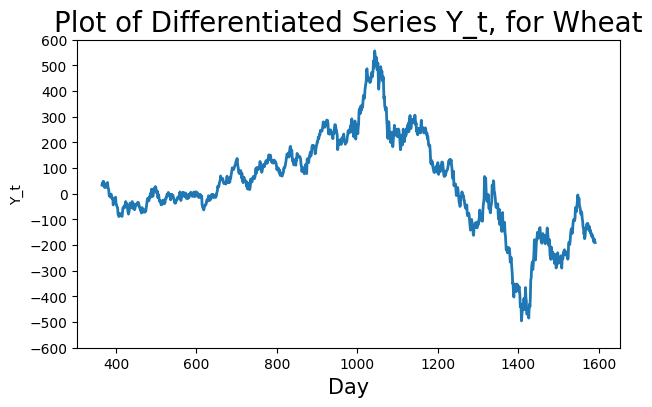

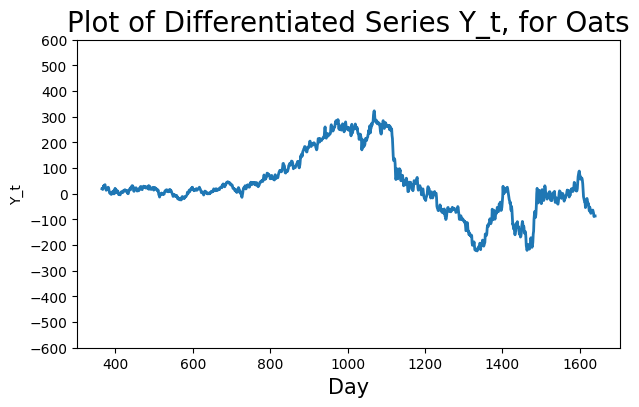

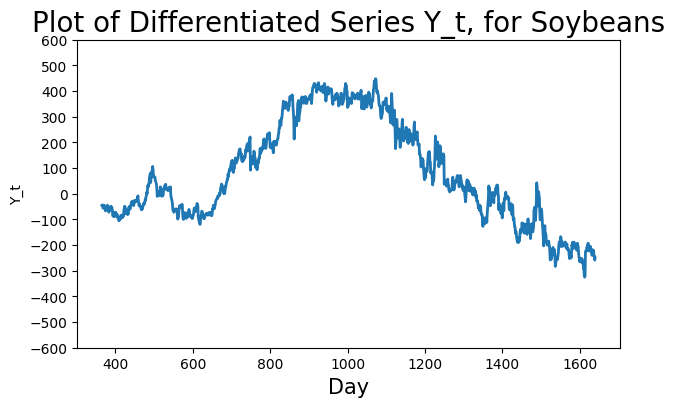

In [4]:
for i, commodity in enumerate(commodities_datasets):
    df_year_diff=commodity[Y_COLUMN].diff(periods=365)
    df_year_diff=df_year_diff.dropna()
    df_year_diff.plot(figsize=(7,4), linewidth=2, fontsize=10)
    plt.title(f"Plot of Differentiated Series Y_t, for {commodities[i]}" ,fontsize=20)
    plt.xlabel('Day', fontsize=15)
    plt.ylabel('Y_t')
    plt.ylim(-600, 600) 
    y_ticks = np.arange(-600, 600+1, 100)
    plt.yticks(y_ticks)
    plt.show()


We can clearly see that these series **do not** exhibit the two aforementioned properties.

Thus, we might want to consider another difference here. We tried to look also at the result of an additional difference - of 1 week (alongside the difference of 1 year). We perform the following differnce on the already differntiated series $Y_t$,
 defining $Z_t \stackrel{\mathrm{def}}{=} Y_t - Y_{t-7} $

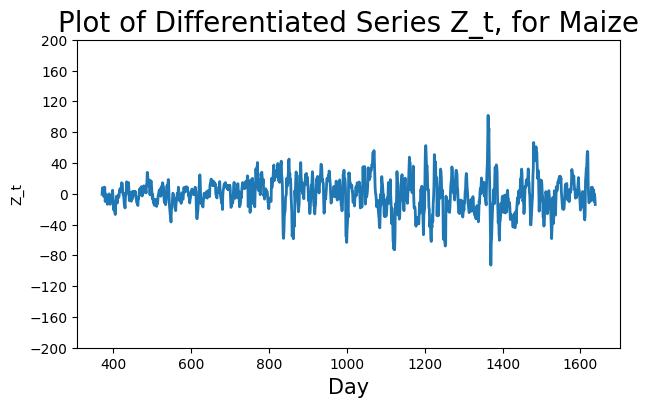

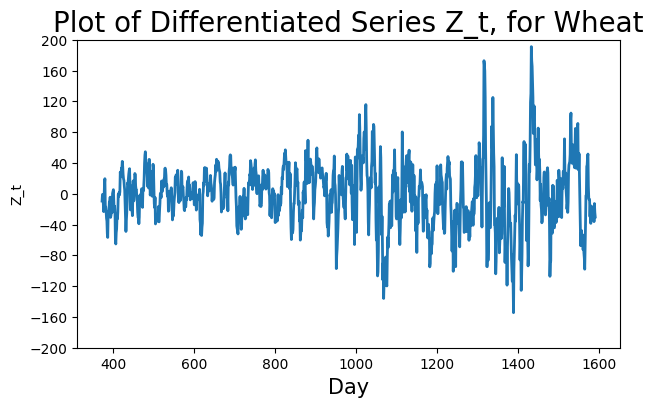

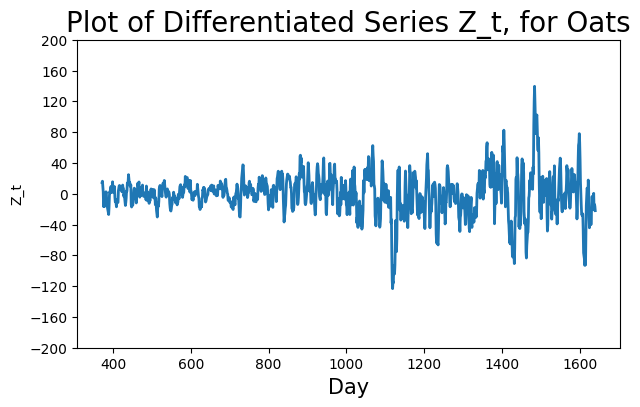

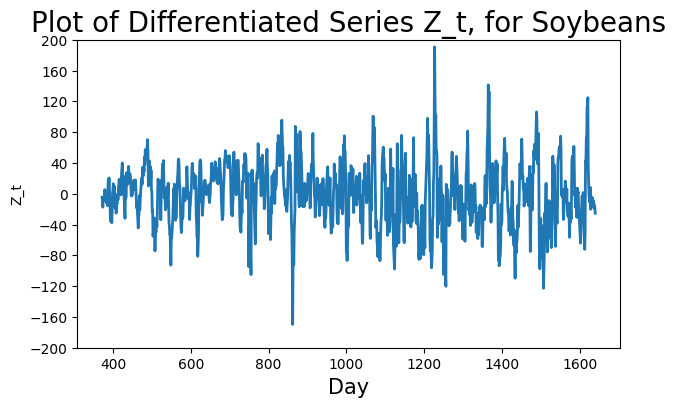

In [5]:
for i, commodity in enumerate(commodities_datasets):
    df_year_diff=commodity[Y_COLUMN].diff(periods=365)
    df_year_last_week_diff = df_year_diff.diff(periods=7)
    df_year_last_week_diff=df_year_last_week_diff.dropna()
    df_year_last_week_diff.plot(figsize=(7,4), linewidth=2, fontsize=10)
    plt.title(f"Plot of Differentiated Series Z_t, for {commodities[i]}",fontsize=20)
    plt.xlabel('Day', fontsize=15)
    plt.ylabel('Z_t')
    plt.ylim(-200, 200)
    y_ticks = np.arange(-200, 200+1, 40)
    plt.yticks(y_ticks)
    plt.show()


Now we can clearly see that the stationarity assumption (scattering around the y=0 line) is much more plausible. In addition it also seems that in general the homoscedasticity assumption holds, if we ignore a few outliers, like in Wheat and Soybeans.

------------------

Let's observe the auto-correlation and partial auto-correlation grapahs (corollograms):

In [6]:
def present_corollograms(index):
    train_df = train_datasets[index]
    train_df = train_df.dropna()[Y_COLUMN].diff(periods=365).diff(periods=7)
    print("Commodity:" + str(commodities[index]))
    plt.figure(figsize=(100, 20)) 
    tsaplots.plot_acf(train_df.dropna(), lags=150)
    plt.title(f"ACF - Commodity {commodities[index]}")
    plt.show()
    plt.figure(figsize=(100, 20))
    tsaplots.plot_pacf(train_df.dropna(), lags=150)
    plt.title(f"PACF - Commodity {commodities[index]}")
    plt.show()
    print()

In the corollograms we will see below, most points are in the CI, but we observe a seasonal effect for the auto correlation coefficients. This will be important when we try to check for ranges of SARIMA parameters to explore in the next section of Parameter selection for SARIMA.


## Parameter selection

The first model we attempt to fit is $SARIMA((p,d,q)(P,D,Q)_{s}$). In this section, we examine several combinations of parameters: $p$, $d$, $q$, $P$, $D$, $Q$, along with a seasonality of $s$ days. 

We will first explain our initial assumptions and then explore other options to find the best parameter selection. To determine the optimal combination of parameters based on the training set, our focus will be on the AIC/BIC scores (lower values indicate a better fit). However, we'll also consider statistical tests of the coefficients, assess various plots, such as residual plots and QQ-plots, to validate the assumption of normally distributed residuals.

Let’s now examine each commodity separately:



### Maize

Commodity:Maize


<Figure size 10000x2000 with 0 Axes>

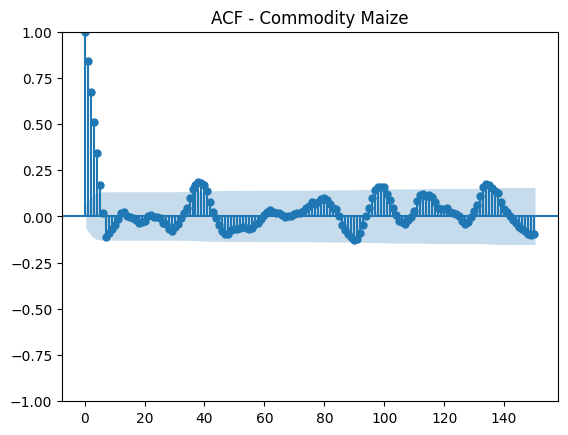

<Figure size 10000x2000 with 0 Axes>

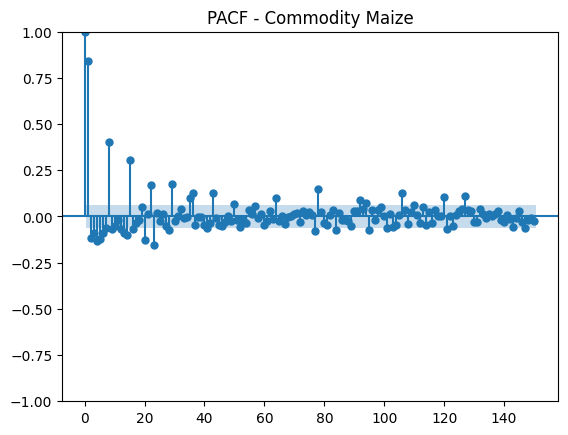

In [7]:
present_corollograms(0)

Regarding the plot of $Z_t$ (both differences), we believe that we should do both differences - with diff = 365, and diff = 7. However, running with the parmater of $s=365$ leads to a crash as this is a large number of hyperparameters and calculations. We'll try to replace it with $s=30$, hopefully it catches not only the seasonality in months but also the yearly effect. Therefore, we'll take $d = 7, D = 1$, for the second difference $Z_t = Y_t - Y_{t-7}$, alongside the seasonality factor of $s=30$ for the first difference $Y_t = X_t - X_{t-365}$.


In the corollograms of $ Z_t$ we see:
* It seems that in the autocorrelation graph the coefficients are decaying to zero. However, after about 30 points (~ a month), it seems that the coefficients are large again, and decay again to zero.
* In the partial autocorrelation graph most of the coefficients are close to zero, yet it seems that there are some large coefficients once in a while.

This behavior we described fits to an Auto Regression model.

* We believed that there is another seasonality in the months - hence we took for start $ P = 1$.
* We see in the partial autocorrelation graph that mostly there are approximately 7 adjacent dominant coefficients which are not in the CI - hence we took $ p = 7 $.
* Our observation didn't lead us to think there is a $MA$ component, hence we take $q=0, Q=0$. However, we'll further explore this option as well if.

That is, the first SARIMA model we'll explore is $SARIMA((7,7,0)(1,1,0)_{30}$):

In [8]:
train_maize = train_datasets[0]
train_maize = train_maize.dropna()[Y_COLUMN]

                                     SARIMAX Results                                      
Dep. Variable:                                Sep   No. Observations:                 1311
Model:             SARIMAX(7, 7, 0)x(1, 1, 0, 30)   Log Likelihood               -5957.538
Date:                            Wed, 18 Sep 2024   AIC                          11933.076
Time:                                    15:23:30   BIC                          11979.425
Sample:                                         0   HQIC                         11950.484
                                           - 1311                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.2026      0.016   -197.376      0.000      -3.234      -3.171
ar.L2         -5.5882      0.055   

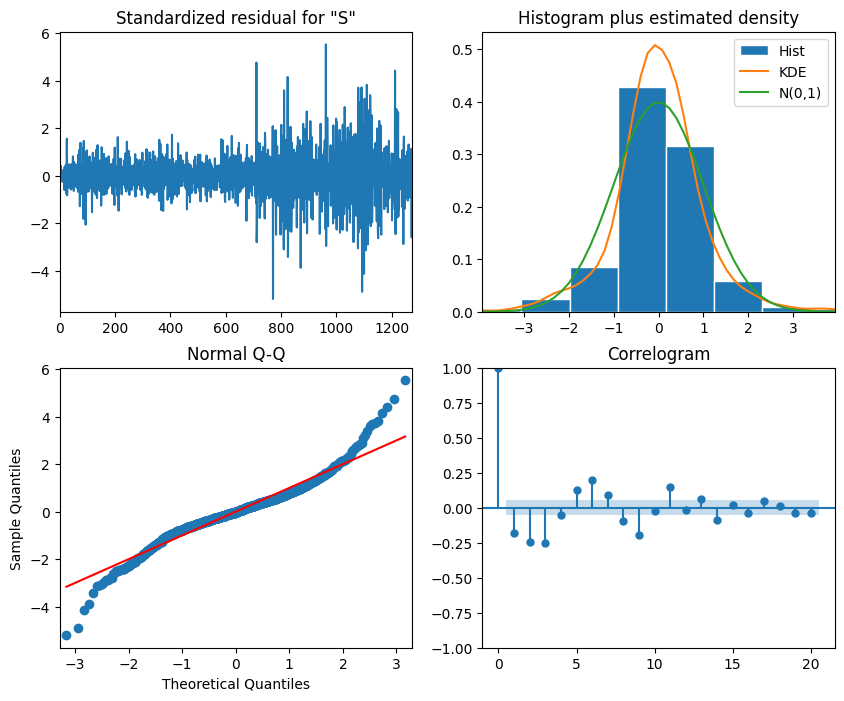

In [9]:
sarmia_maize_770110 = SARIMAX(train_maize, order=(7, 7, 0),seasonal_order=(1, 1, 0, 30))
sarmia_maize_770110_fit = sarmia_maize_770110.fit(disp=False)
print(sarmia_maize_770110_fit.summary())
sarmia_maize_770110_fit.plot_diagnostics(lags=20,figsize=(10, 8));


We'll try to include more parameters and see if it is worthy.

For example enlarge to $D=2$ in:

$SARIMA((7,7,0)(1,2,0)_{30}$)

                                     SARIMAX Results                                      
Dep. Variable:                                Sep   No. Observations:                 1311
Model:             SARIMAX(7, 7, 0)x(1, 2, 0, 30)   Log Likelihood               -6299.941
Date:                            Wed, 18 Sep 2024   AIC                          12617.881
Time:                                    15:25:08   BIC                          12664.016
Sample:                                         0   HQIC                         12635.229
                                           - 1311                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.1910      0.016   -201.229      0.000      -3.222      -3.160
ar.L2         -5.5606      0.052   

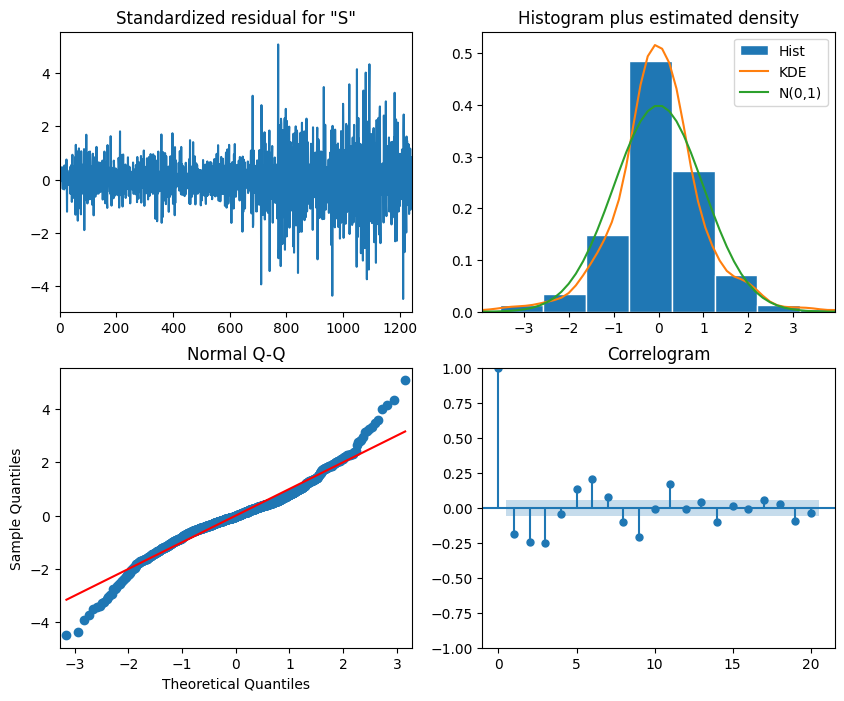

In [10]:
sarmia_maize_770120 = SARIMAX(train_maize, order=(7, 7, 0),seasonal_order=(1, 2, 0, 30))
sarmia_maize_770120_fit = sarmia_maize_770120.fit(disp=False)
print(sarmia_maize_770120_fit.summary())
sarmia_maize_770120_fit.plot_diagnostics(lags=20,figsize=(10, 8));


Though the plots look quite the same and the results are statistically significent, we can see we got bigger AIC/BIC values so we won't go in this direction

We can see that trying a smaller value of $p$ ($p=1$, for example) leads to a deterioration in AIC, BIC as well. So we will keep $p=7$ as well:

$SARIMA((1,7,0)(1,1,0)_{30}$)

                                     SARIMAX Results                                      
Dep. Variable:                                Sep   No. Observations:                 1311
Model:             SARIMAX(1, 7, 0)x(1, 1, 0, 30)   Log Likelihood               -7682.202
Date:                            Wed, 18 Sep 2024   AIC                          15370.403
Time:                                    15:25:18   BIC                          15385.853
Sample:                                         0   HQIC                         15376.206
                                           - 1311                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8579      0.009    -90.842      0.000      -0.876      -0.839
ar.S.L30      -0.4388      0.018   

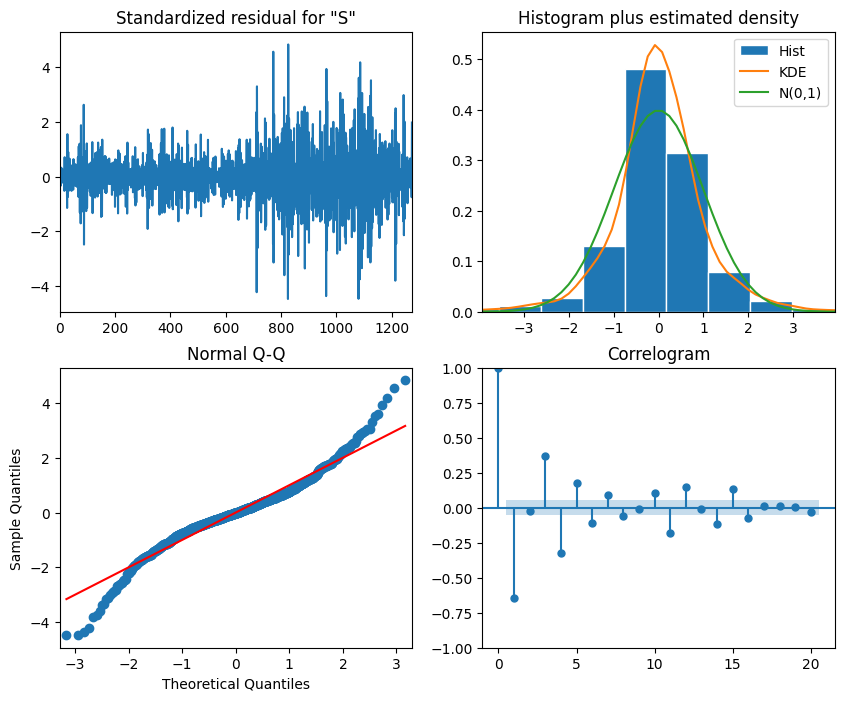

In [11]:
sarmia_maize_170110 = SARIMAX(train_maize, order=(1, 7, 0),seasonal_order=(1, 1, 0, 30))
sarmia_maize_170110_fit = sarmia_maize_170110.fit(disp=False)
print(sarmia_maize_170110_fit.summary())
sarmia_maize_170110_fit.plot_diagnostics(lags=20,figsize=(10, 8));


We will try to change to $d=1$ to see if it is worthy:

$SARIMA((7,1,0)(1,1,0)_{30}$)

                                     SARIMAX Results                                      
Dep. Variable:                                Sep   No. Observations:                 1311
Model:             SARIMAX(7, 1, 0)x(1, 1, 0, 30)   Log Likelihood               -4247.841
Date:                            Wed, 18 Sep 2024   AIC                           8513.682
Time:                                    15:25:24   BIC                           8560.073
Sample:                                         0   HQIC                          8531.101
                                           - 1311                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0518      0.024      2.168      0.030       0.005       0.099
ar.L2         -0.0042      0.022   

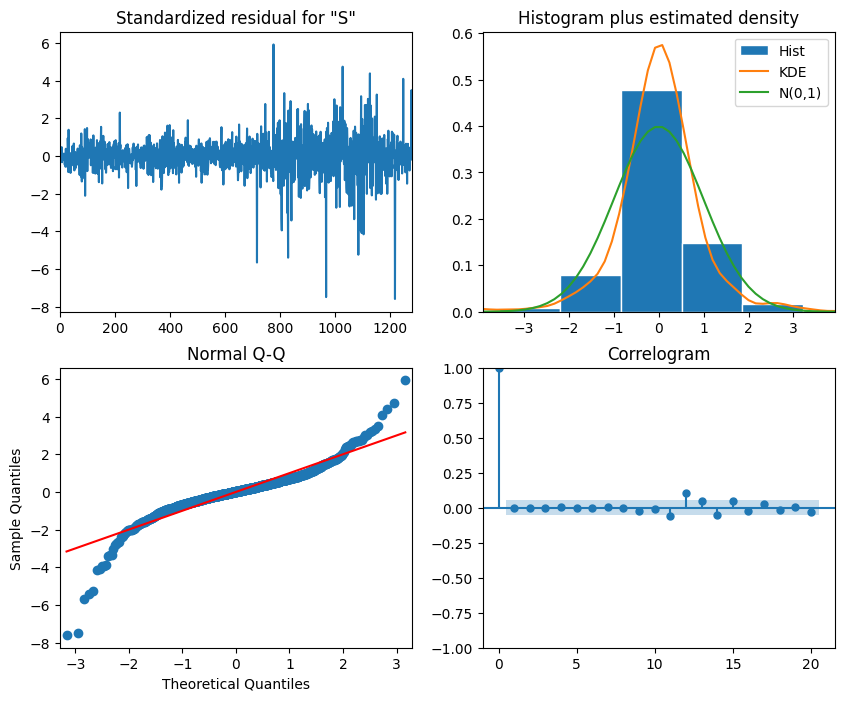

In [12]:
sarmia_maize_710110 = SARIMAX(train_maize, order=(7, 1, 0),seasonal_order=(1, 1, 0, 30))
sarmia_maize_710110_fit = sarmia_maize_710110.fit(disp=False)
print(sarmia_maize_710110_fit.summary())
sarmia_maize_710110_fit.plot_diagnostics(lags=20,figsize=(10, 8));


Though the AIC/BIC are smaller, the statistical tests of the coefficients are not significant at all.

The last try for Maize will be enlarging $P$ and see if this has merits. We'll try $P=2$ as start:

$SARIMA((7,7,0)(2,1,0)_{30}$)

                                     SARIMAX Results                                      
Dep. Variable:                                Sep   No. Observations:                 1311
Model:             SARIMAX(7, 7, 0)x(2, 1, 0, 30)   Log Likelihood               -5902.857
Date:                            Wed, 18 Sep 2024   AIC                          11825.715
Time:                                    15:26:28   BIC                          11877.214
Sample:                                         0   HQIC                         11845.057
                                           - 1311                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.2044      0.015   -215.675      0.000      -3.234      -3.175
ar.L2         -5.5863      0.052   

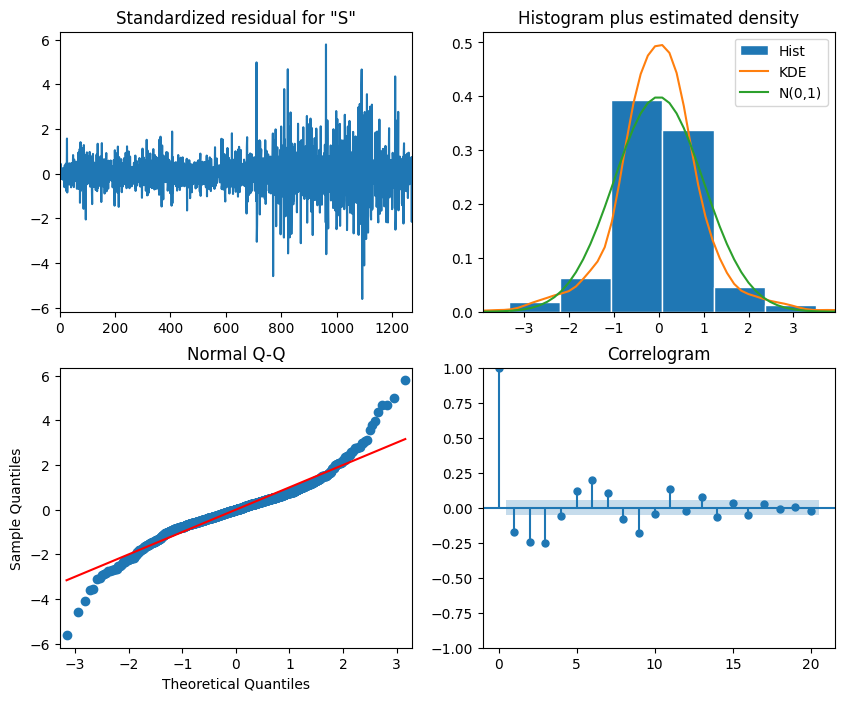

In [13]:
sarmia_maize_770210 = SARIMAX(train_maize, order=(7, 7, 0),seasonal_order=(2, 1, 0, 30))
sarmia_maize_770210_fit = sarmia_maize_770210.fit(disp=False)
print(sarmia_maize_770210_fit.summary())
sarmia_maize_770210_fit.plot_diagnostics(lags=20,figsize=(10, 8));


Compared to our best model so far, which was the initial conjecture ($SARIMA((7,7,0)(1,1,0)_{30}$), we can see that all statistical tests are significant and that the plots are quite the same. We can observe a good fit in the QQ-plot to the normality assumption of the residuals, and also the residuals plot demonstrates that the stationarity and homoscedasticity assumption hold in general. We can see that the change to $P=2$ resulted in an improvement in the AIC/BIC values. We do not want to try bigger values for the parameters to avoid overfitting, so we conclude the maize experiments by stating that the $SARIMA((7,7,0)(2,1,0)_{30}$ above is the best model for the train set of maize.

Best model for maize: $SARIMA((7,7,0)(2,1,0)_{30}$ 

------------------

### Wheat

Commodity:Wheat


<Figure size 10000x2000 with 0 Axes>

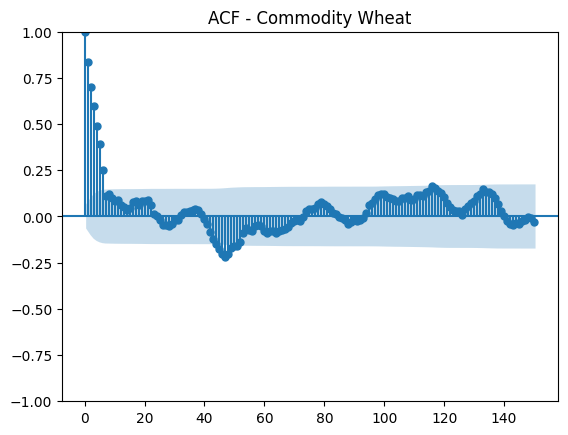

<Figure size 10000x2000 with 0 Axes>

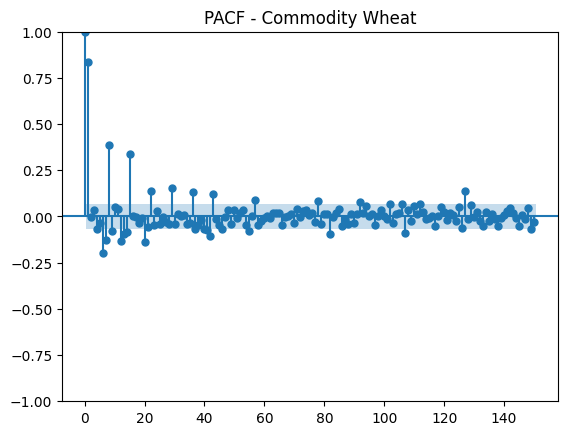

In [14]:
present_corollograms(1)

The inital conjectures for the maize Sarima model's parameters are also relevant here, because the corollograms seem to have similar properties.

Hence, we'll first try the $SARIMA((7,7,0)(1,1,0)_{30}$):

In [15]:
train_wheat = train_datasets[1]
train_wheat = train_wheat.dropna()[Y_COLUMN]

                                     SARIMAX Results                                      
Dep. Variable:                                Sep   No. Observations:                 1273
Model:             SARIMAX(7, 7, 0)x(1, 1, 0, 30)   Log Likelihood               -6720.348
Date:                            Wed, 18 Sep 2024   AIC                          13458.695
Time:                                    15:26:55   BIC                          13504.772
Sample:                                         0   HQIC                         13476.027
                                           - 1273                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.2058      0.017   -189.422      0.000      -3.239      -3.173
ar.L2         -5.6026      0.052   

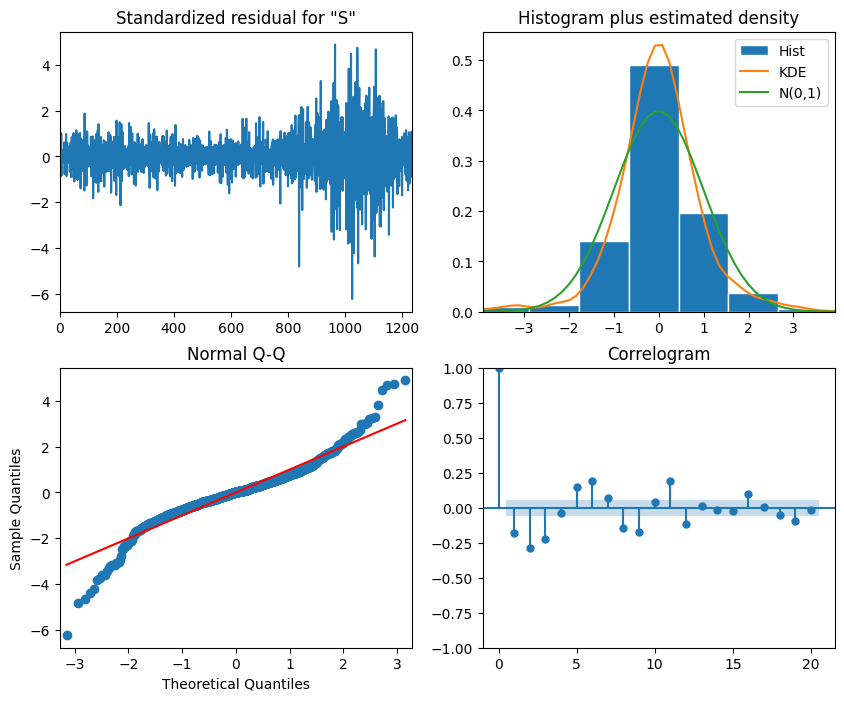

In [16]:
sarmia_wheat_770110 = SARIMAX(train_wheat, order=(7, 7, 0),seasonal_order=(1, 1, 0, 30))
sarmia_wheat_770110_fit = sarmia_wheat_770110.fit(disp=False)
print(sarmia_wheat_770110_fit.summary())
sarmia_wheat_770110_fit.plot_diagnostics(lags=20,figsize=(10, 8));


We will also try similar changes with respect to this baseline, trying to see if they help or leads to a deterioration in AIC, BIC.

$SARIMA((1,7,0)(1,1,0)_{30}$)

                                     SARIMAX Results                                      
Dep. Variable:                                Sep   No. Observations:                 1273
Model:             SARIMAX(1, 7, 0)x(1, 1, 0, 30)   Log Likelihood               -8411.856
Date:                            Wed, 18 Sep 2024   AIC                          16829.712
Time:                                    15:27:04   BIC                          16845.071
Sample:                                         0   HQIC                         16835.489
                                           - 1273                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8407      0.011    -77.301      0.000      -0.862      -0.819
ar.S.L30      -0.4661      0.015   

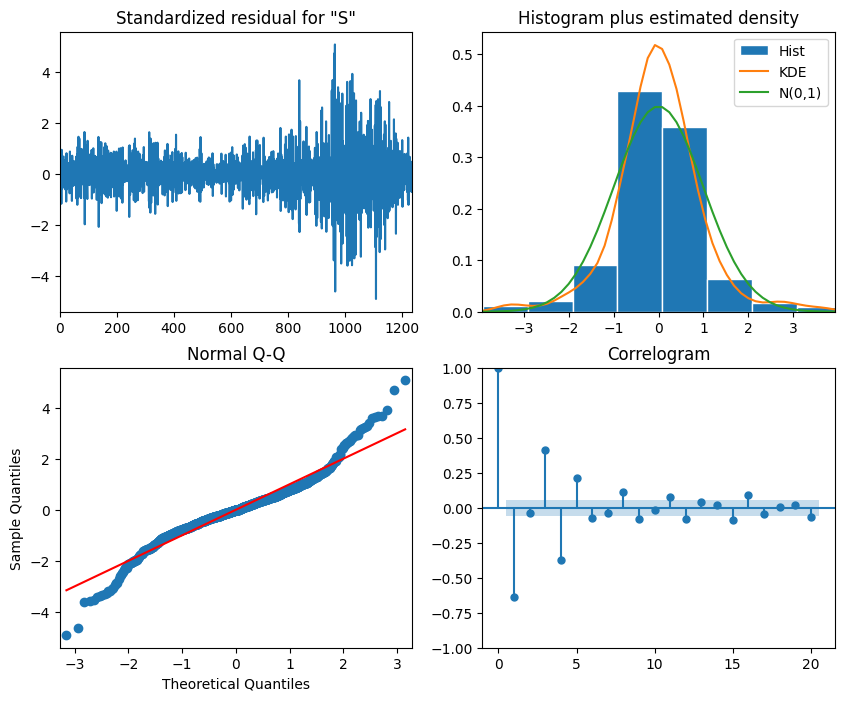

In [17]:
sarmia_wheat_170110 = SARIMAX(train_wheat, order=(1, 7, 0),seasonal_order=(1, 1, 0, 30))
sarmia_wheat_170110_fit = sarmia_wheat_170110.fit(disp=False)
print(sarmia_wheat_170110_fit.summary())
sarmia_wheat_170110_fit.plot_diagnostics(lags=20,figsize=(10, 8));


There is a severe deterioration in AIC and BIC results.

$SARIMA((7,1,0)(1,1,0)_{30}$)

                                     SARIMAX Results                                      
Dep. Variable:                                Sep   No. Observations:                 1273
Model:             SARIMAX(7, 1, 0)x(1, 1, 0, 30)   Log Likelihood               -4985.085
Date:                            Wed, 18 Sep 2024   AIC                           9988.169
Time:                                    15:27:11   BIC                          10034.290
Sample:                                         0   HQIC                         10005.513
                                           - 1273                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0361      0.020     -1.849      0.065      -0.074       0.002
ar.L2         -0.0924      0.020   

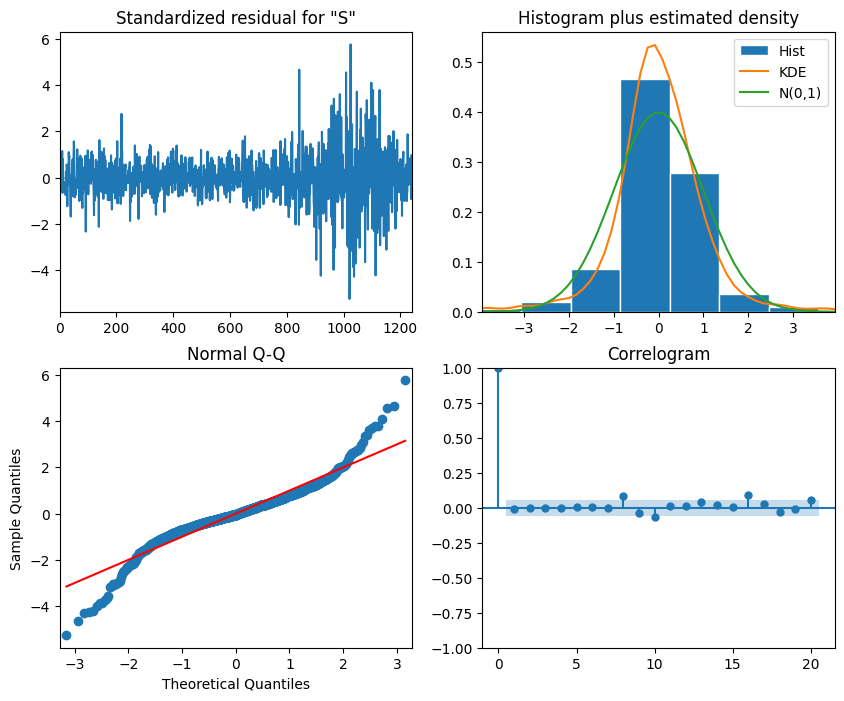

In [18]:
sarmia_wheat_710110 = SARIMAX(train_wheat, order=(7, 1, 0),seasonal_order=(1, 1, 0, 30))
sarmia_wheat_710110_fit = sarmia_wheat_710110.fit(disp=False)
print(sarmia_wheat_710110_fit.summary())
sarmia_wheat_710110_fit.plot_diagnostics(lags=20,figsize=(10, 8));


The coefficients tests are not statistically significant

$SARIMA((7,7,0)(2,1,0)_{30}$)

                                     SARIMAX Results                                      
Dep. Variable:                                Sep   No. Observations:                 1273
Model:             SARIMAX(7, 7, 0)x(2, 1, 0, 30)   Log Likelihood               -6644.538
Date:                            Wed, 18 Sep 2024   AIC                          13309.076
Time:                                    15:28:13   BIC                          13360.272
Sample:                                         0   HQIC                         13328.333
                                           - 1273                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.2081      0.016   -201.557      0.000      -3.239      -3.177
ar.L2         -5.5951      0.048   

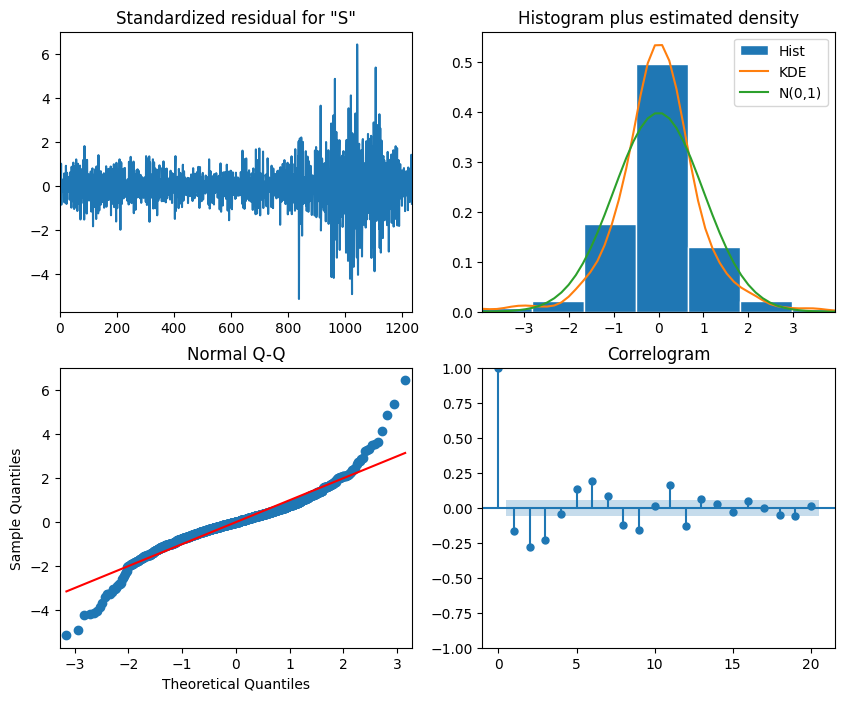

In [19]:
sarmia_wheat_770210 = SARIMAX(train_wheat, order=(7, 7, 0),seasonal_order=(2, 1, 0, 30))
sarmia_wheat_770210_fit = sarmia_wheat_770210.fit(disp=False)
print(sarmia_wheat_770210_fit.summary())
sarmia_wheat_770210_fit.plot_diagnostics(lags=20,figsize=(10, 8));


There is a small improvement in AIC/BIC, though the QQ-plot suffers slightly from this change (the outliers are worse). However, we'll still favor this model when comparing to the $SARIMA((7,7,0)(1,1,0)_{30}$) first suggested because the improvement in the AIC/BIC is more of our main focus in here.

Best model for wheat: $SARIMA((7,7,0)(2,1,0)_{30}$)

------------

### Oats

Commodity:Oats


<Figure size 10000x2000 with 0 Axes>

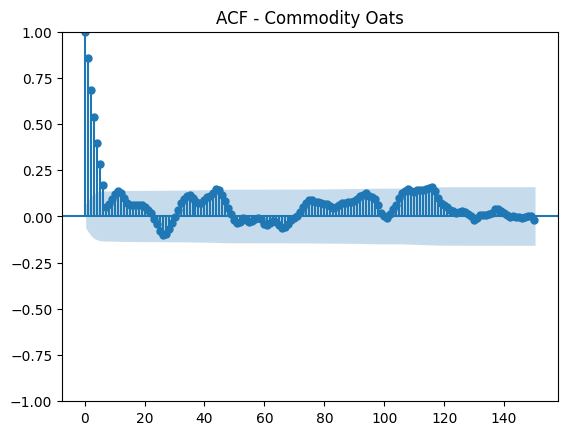

<Figure size 10000x2000 with 0 Axes>

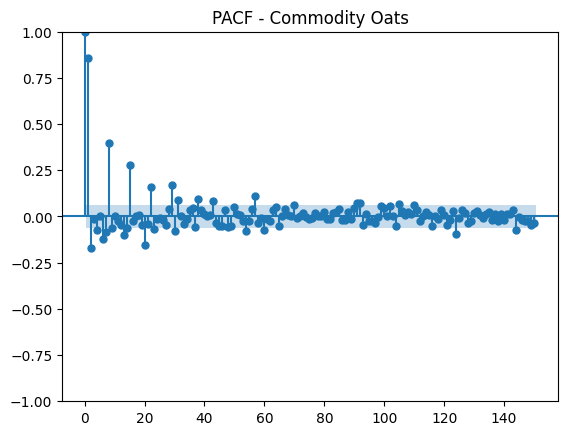

In [20]:
present_corollograms(2)

The inital conjectures for the maize Sarima model's parameters are also relevant here, because the corollograms seem to have similar properties.
Hence, we'll first try the $SARIMA((7,7,0)(1,1,0)_{30}$):

In [21]:
train_oats = train_datasets[2]
train_oats = train_oats.dropna()[Y_COLUMN]

                                     SARIMAX Results                                      
Dep. Variable:                                Sep   No. Observations:                 1312
Model:             SARIMAX(7, 7, 0)x(1, 1, 0, 30)   Log Likelihood               -6221.782
Date:                            Wed, 18 Sep 2024   AIC                          12461.564
Time:                                    15:28:45   BIC                          12507.920
Sample:                                         0   HQIC                         12478.974
                                           - 1312                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.0630      0.016   -188.059      0.000      -3.095      -3.031
ar.L2         -5.1751      0.049   

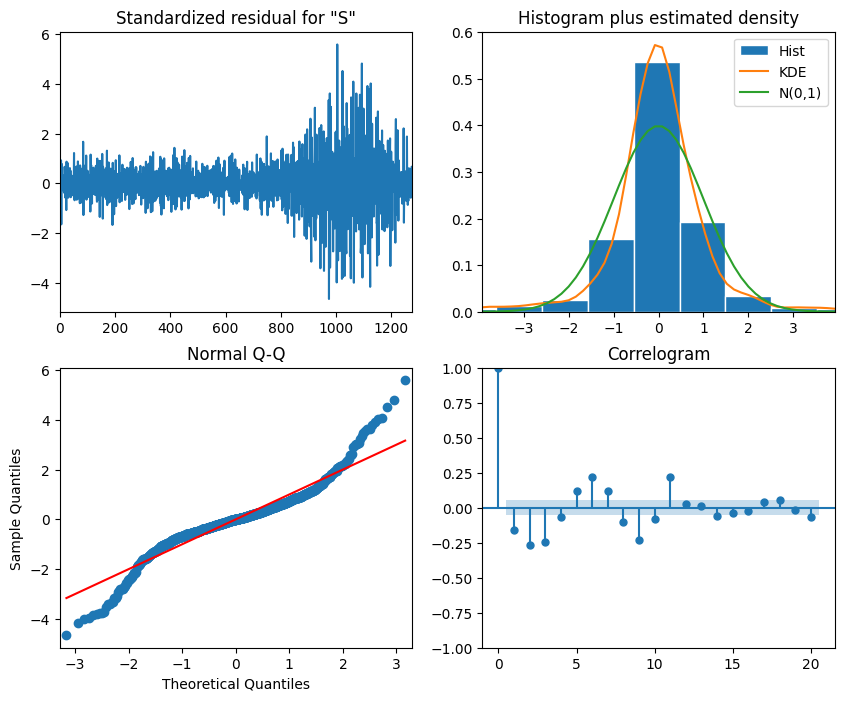

In [22]:
sarmia_oats_770110 = SARIMAX(train_oats, order=(7, 7, 0),seasonal_order=(1, 1, 0, 30))
sarmia_oats_770110_fit = sarmia_oats_770110.fit(disp=False)
print(sarmia_oats_770110_fit.summary())
sarmia_oats_770110_fit.plot_diagnostics(lags=20,figsize=(10, 8));

We will also try similar changes with respect to this baseline, trying to see if they help or leads to a deterioration in AIC, BIC.

$SARIMA((1,7,0)(1,1,0)_{30}$)

                                     SARIMAX Results                                      
Dep. Variable:                                Sep   No. Observations:                 1312
Model:             SARIMAX(1, 7, 0)x(1, 1, 0, 30)   Log Likelihood               -7853.687
Date:                            Wed, 18 Sep 2024   AIC                          15713.374
Time:                                    15:28:54   BIC                          15728.826
Sample:                                         0   HQIC                         15719.177
                                           - 1312                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8323      0.011    -76.941      0.000      -0.854      -0.811
ar.S.L30      -0.5353      0.013   

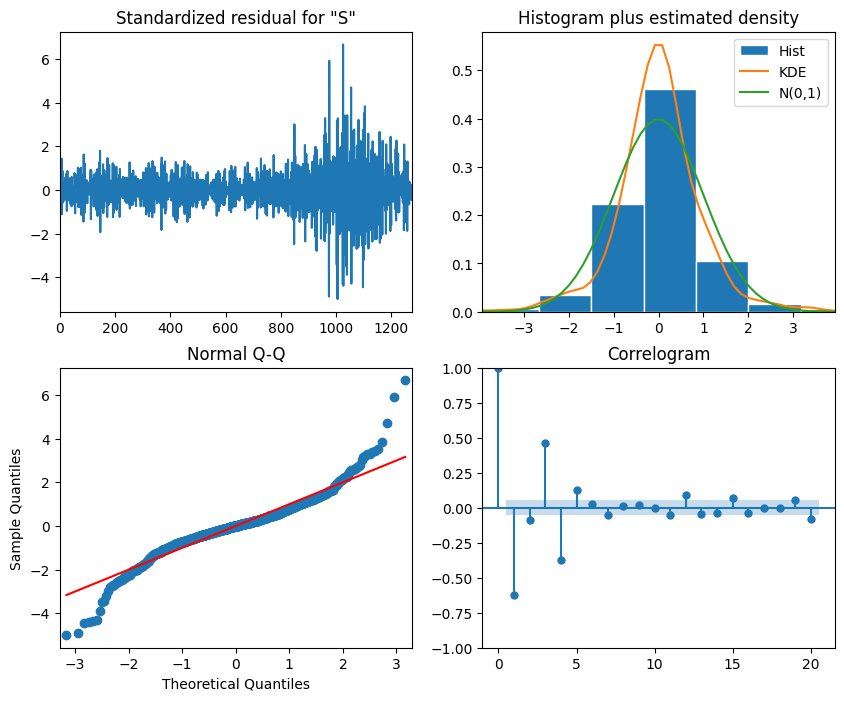

In [23]:
sarmia_oats_170110 = SARIMAX(train_oats, order=(1, 7, 0),seasonal_order=(1, 1, 0, 30))
sarmia_oats_170110_fit = sarmia_oats_170110.fit(disp=False)
print(sarmia_oats_170110_fit.summary())
sarmia_oats_170110_fit.plot_diagnostics(lags=20,figsize=(10, 8));


In this model the AIC/BIC are much worse.

$SARIMA((7,1,0)(1,1,0)_{30}$)

                                     SARIMAX Results                                      
Dep. Variable:                                Sep   No. Observations:                 1312
Model:             SARIMAX(7, 1, 0)x(1, 1, 0, 30)   Log Likelihood               -4440.412
Date:                            Wed, 18 Sep 2024   AIC                           8898.824
Time:                                    15:29:01   BIC                           8945.222
Sample:                                         0   HQIC                          8916.245
                                           - 1312                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1212      0.018      6.646      0.000       0.085       0.157
ar.L2         -0.0754      0.019   

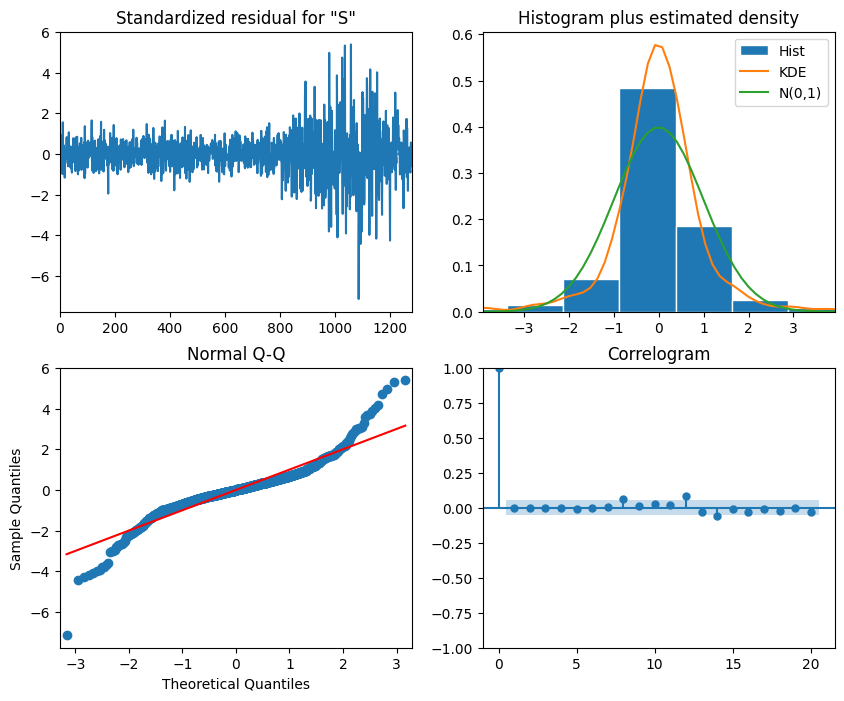

In [24]:
sarmia_oats_710110 = SARIMAX(train_oats, order=(7, 1, 0),seasonal_order=(1, 1, 0, 30))
sarmia_oats_710110_fit = sarmia_oats_710110.fit(disp=False)
print(sarmia_oats_710110_fit.summary())
sarmia_oats_710110_fit.plot_diagnostics(lags=20,figsize=(10, 8));


In this model above the Ljung-Box is not statistically significant, and also some of the coefficients tests are not.

Let's try again to change to $P=2$:

$SARIMA((7,7,0)(2,1,0)_{30}$)

                                     SARIMAX Results                                      
Dep. Variable:                                Sep   No. Observations:                 1312
Model:             SARIMAX(7, 7, 0)x(2, 1, 0, 30)   Log Likelihood               -6152.675
Date:                            Wed, 18 Sep 2024   AIC                          12325.349
Time:                                    15:30:14   BIC                          12376.856
Sample:                                         0   HQIC                         12344.693
                                           - 1312                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.0460      0.015   -205.496      0.000      -3.075      -3.017
ar.L2         -5.1228      0.045   

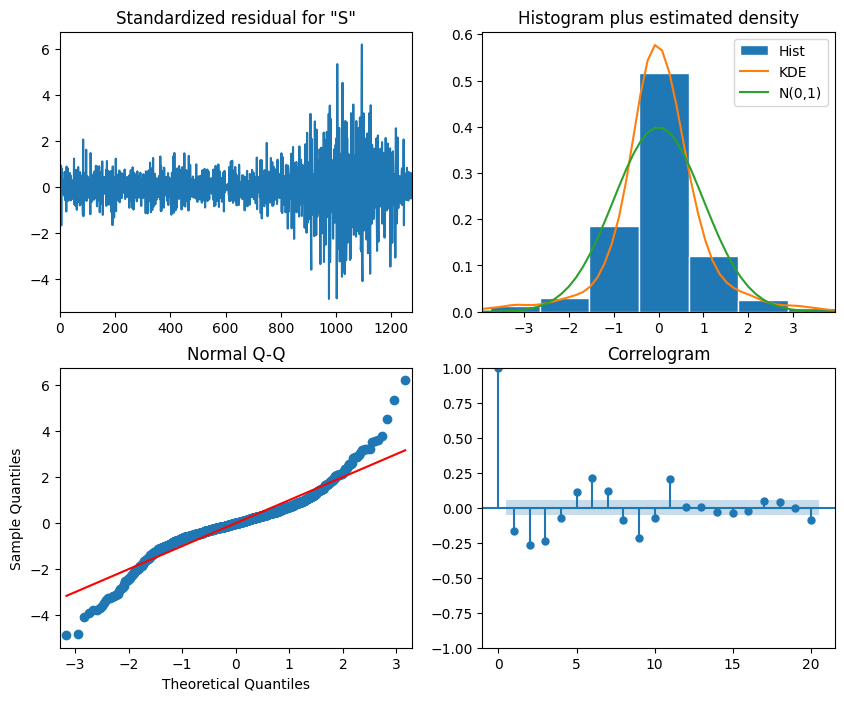

In [25]:
sarmia_oats_770210 = SARIMAX(train_oats, order=(7, 7, 0),seasonal_order=(2, 1, 0, 30))
sarmia_oats_770210_fit = sarmia_oats_770210.fit(disp=False)
print(sarmia_oats_770210_fit.summary())
sarmia_oats_770210_fit.plot_diagnostics(lags=20,figsize=(10, 8));


There is a small improvement in AIC/BIC, and also in the QQ-plot. In all oats' models the residuals plot do not seem to have the homoscedasticity property, which may make us doubt ourselves when trying to apply SARIMA in this context. However, the other plots seem good and the statistical tests are significant so we'll stick with this method and won't drop it in oats.

Best model for oats: $SARIMA((7,7,0)(2,1,0)_{30}$)

-----------

### Soybeans

Commodity:Soybeans


<Figure size 10000x2000 with 0 Axes>

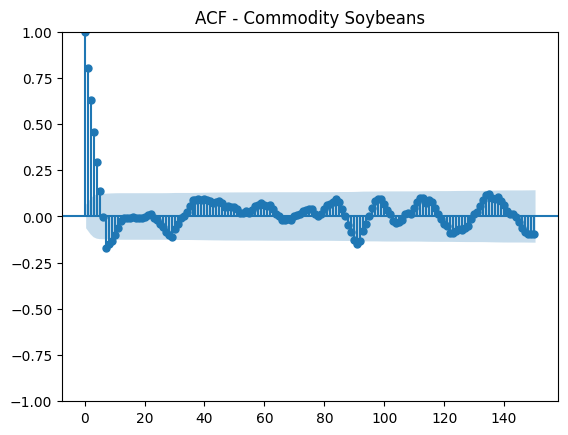

<Figure size 10000x2000 with 0 Axes>

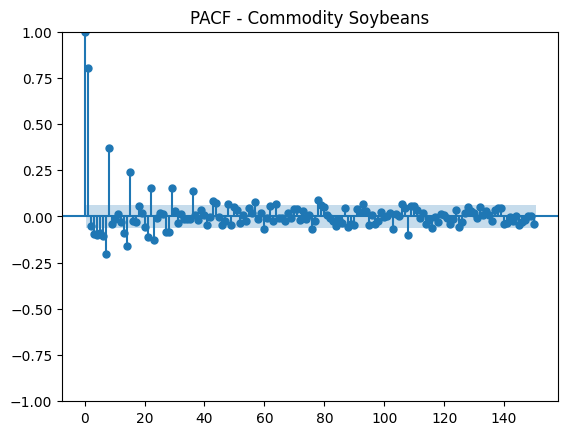

In [26]:
present_corollograms(3)

The inital conjectures for the maize Sarima model's parameters are also relevant here, because the corollograms seem to have similar properties.
Hence, we'll first try the $SARIMA((7,7,0)(1,1,0)_{30}$):

In [27]:
train_soybeans = train_datasets[3]
train_soybeans = train_soybeans.dropna()[Y_COLUMN]

                                     SARIMAX Results                                      
Dep. Variable:                                Sep   No. Observations:                 1312
Model:             SARIMAX(7, 7, 0)x(1, 1, 0, 30)   Log Likelihood               -7028.618
Date:                            Wed, 18 Sep 2024   AIC                          14075.235
Time:                                    15:30:49   BIC                          14121.592
Sample:                                         0   HQIC                         14092.645
                                           - 1312                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.1911      0.016   -201.170      0.000      -3.222      -3.160
ar.L2         -5.4841      0.054   

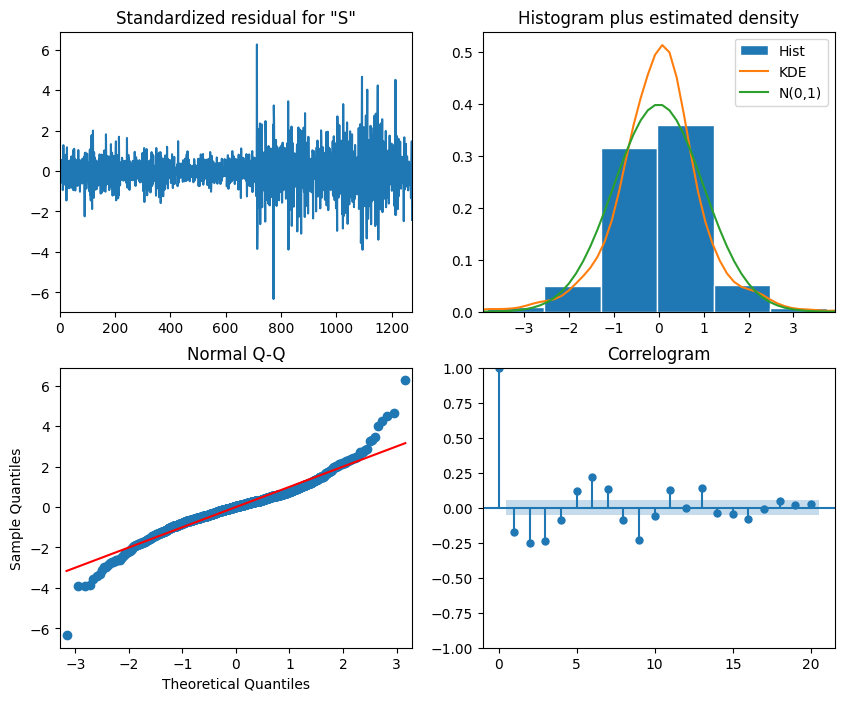

In [28]:
sarmia_soybeans_770110 = SARIMAX(train_soybeans, order=(7, 7, 0),seasonal_order=(1, 1, 0, 30))
sarmia_soybeans_770110_fit = sarmia_soybeans_770110.fit(disp=False)
print(sarmia_soybeans_770110_fit.summary())
sarmia_soybeans_770110_fit.plot_diagnostics(lags=20,figsize=(10, 8));

We will also try similar changes with respect to this baseline, trying to see if they help or leads to a deterioration in AIC, BIC.


$SARIMA((1,7,0)(1,1,0)_{30}$)

                                     SARIMAX Results                                      
Dep. Variable:                                Sep   No. Observations:                 1312
Model:             SARIMAX(1, 7, 0)x(1, 1, 0, 30)   Log Likelihood               -8723.255
Date:                            Wed, 18 Sep 2024   AIC                          17452.509
Time:                                    15:31:01   BIC                          17467.961
Sample:                                         0   HQIC                         17458.313
                                           - 1312                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8688      0.008   -104.652      0.000      -0.885      -0.852
ar.S.L30      -0.4707      0.017   

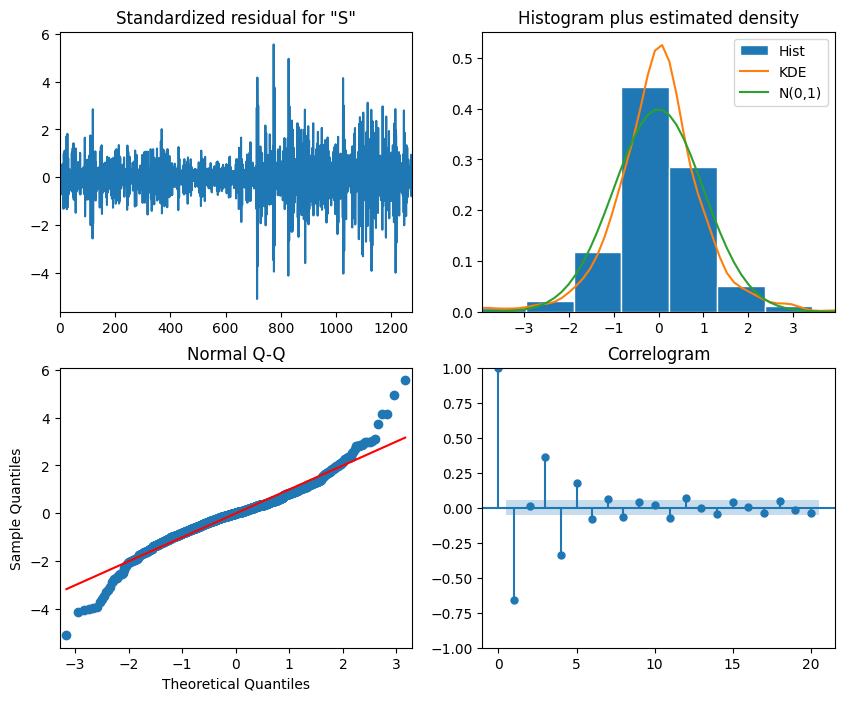

In [29]:
sarmia_soybeans_170110 = SARIMAX(train_soybeans, order=(1, 7, 0),seasonal_order=(1, 1, 0, 30))
sarmia_soybeans_170110_fit = sarmia_soybeans_170110.fit(disp=False)
print(sarmia_soybeans_170110_fit.summary())
sarmia_soybeans_170110_fit.plot_diagnostics(lags=20,figsize=(10, 8));

The AIC/BIC are much worse in here.

$SARIMA((7,1,0)(1,1,0)_{30}$)

                                     SARIMAX Results                                      
Dep. Variable:                                Sep   No. Observations:                 1312
Model:             SARIMAX(7, 1, 0)x(1, 1, 0, 30)   Log Likelihood               -5244.906
Date:                            Wed, 18 Sep 2024   AIC                          10507.811
Time:                                    15:31:09   BIC                          10554.210
Sample:                                         0   HQIC                         10525.233
                                           - 1312                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0260      0.022     -1.208      0.227      -0.068       0.016
ar.L2         -0.0129      0.028   

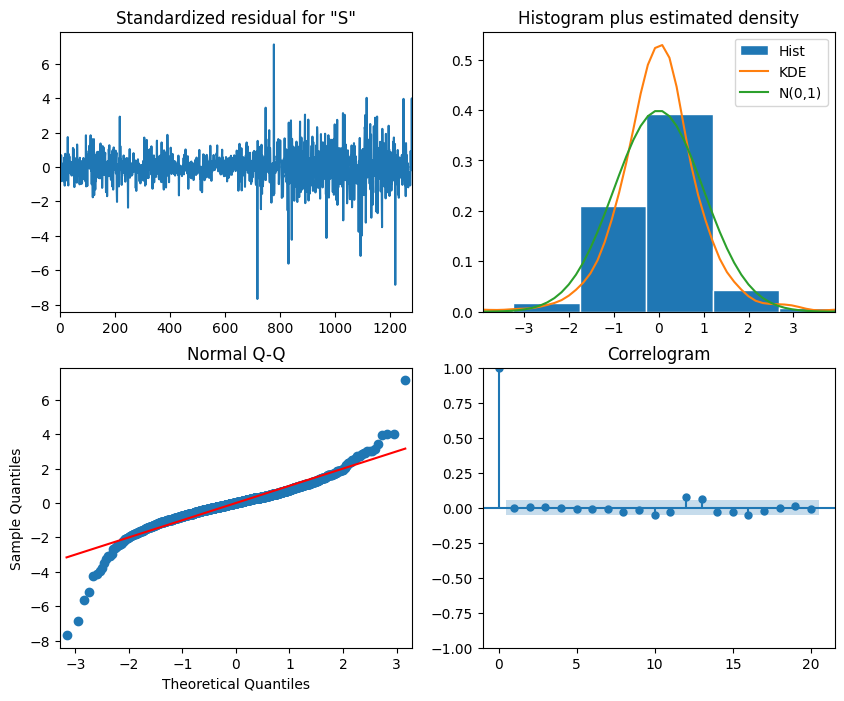

In [30]:
sarmia_soybeans_710110 = SARIMAX(train_soybeans, order=(7, 1, 0),seasonal_order=(1, 1, 0, 30))
sarmia_soybeans_710110_fit = sarmia_soybeans_710110.fit(disp=False)
print(sarmia_soybeans_710110_fit.summary())
sarmia_soybeans_710110_fit.plot_diagnostics(lags=20,figsize=(10, 8));

The statistical tests are not significant.

$SARIMA((7,7,0)(2,1,0)_{30}$)

                                     SARIMAX Results                                      
Dep. Variable:                                Sep   No. Observations:                 1312
Model:             SARIMAX(7, 7, 0)x(2, 1, 0, 30)   Log Likelihood               -6970.110
Date:                            Wed, 18 Sep 2024   AIC                          13960.220
Time:                                    15:32:44   BIC                          14011.728
Sample:                                         0   HQIC                         13979.565
                                           - 1312                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.1778      0.015   -208.858      0.000      -3.208      -3.148
ar.L2         -5.4318      0.051   

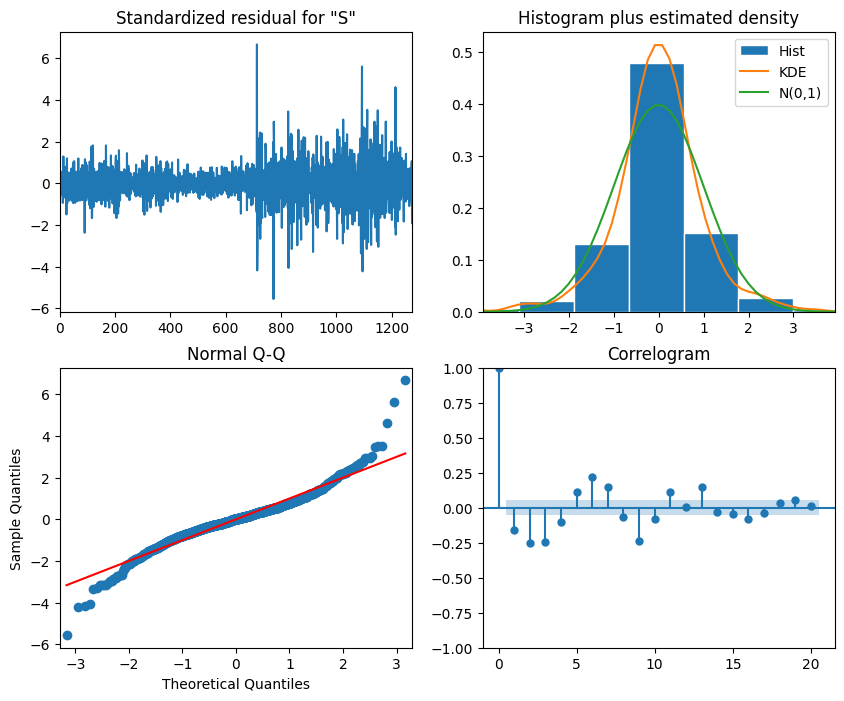

In [31]:
sarmia_soybeans_770210 = SARIMAX(train_soybeans, order=(7, 7, 0),seasonal_order=(2, 1, 0, 30))
sarmia_soybeans_770210_fit = sarmia_soybeans_770210.fit(disp=False)
print(sarmia_soybeans_770210_fit.summary())
sarmia_soybeans_770210_fit.plot_diagnostics(lags=20,figsize=(10, 8));

There is a small improvement in AIC/BIC, but also in the QQ-plot and in the fit of the distrubtions in the histogram. In all soybeans' models the residuals plot do not seem to have the homoscedasticity property, which may make us doubt ourselves when trying to apply SARIMA in this context. However, the other plots seem good and the statistical tests are significant so we'll stick with this method and won't drop it in soybeans.

Best model for soybeans: $SARIMA((7,7,0)(2,1,0)_{30}$)

To sum up, in this section we aimed to choose the best SARIMA models for each commodity type: maize, wheat, oats, and soybeans. We assessed the quality of various parameter combinations for SARIMA, initially based on observations from the correlograms (plots of the auto-correlations and partial auto-correlations). Our focus was on optimizing the AIC/BIC metrics, aiming to find the model with the lowest values. However, we also paid close attention to residual plots and other diagnostics, and checked the statistical significance of the models. It appears that for all four types of commodities, the best SARIMA model was the same (based on the respective training sets), and it was $SARIMA((7,7,0)(2,1,0)_{30}$).



------------


## Forecasting with the chosen model: $SARIMA((7,7,0)(2,1,0)_{30}$

### Maize

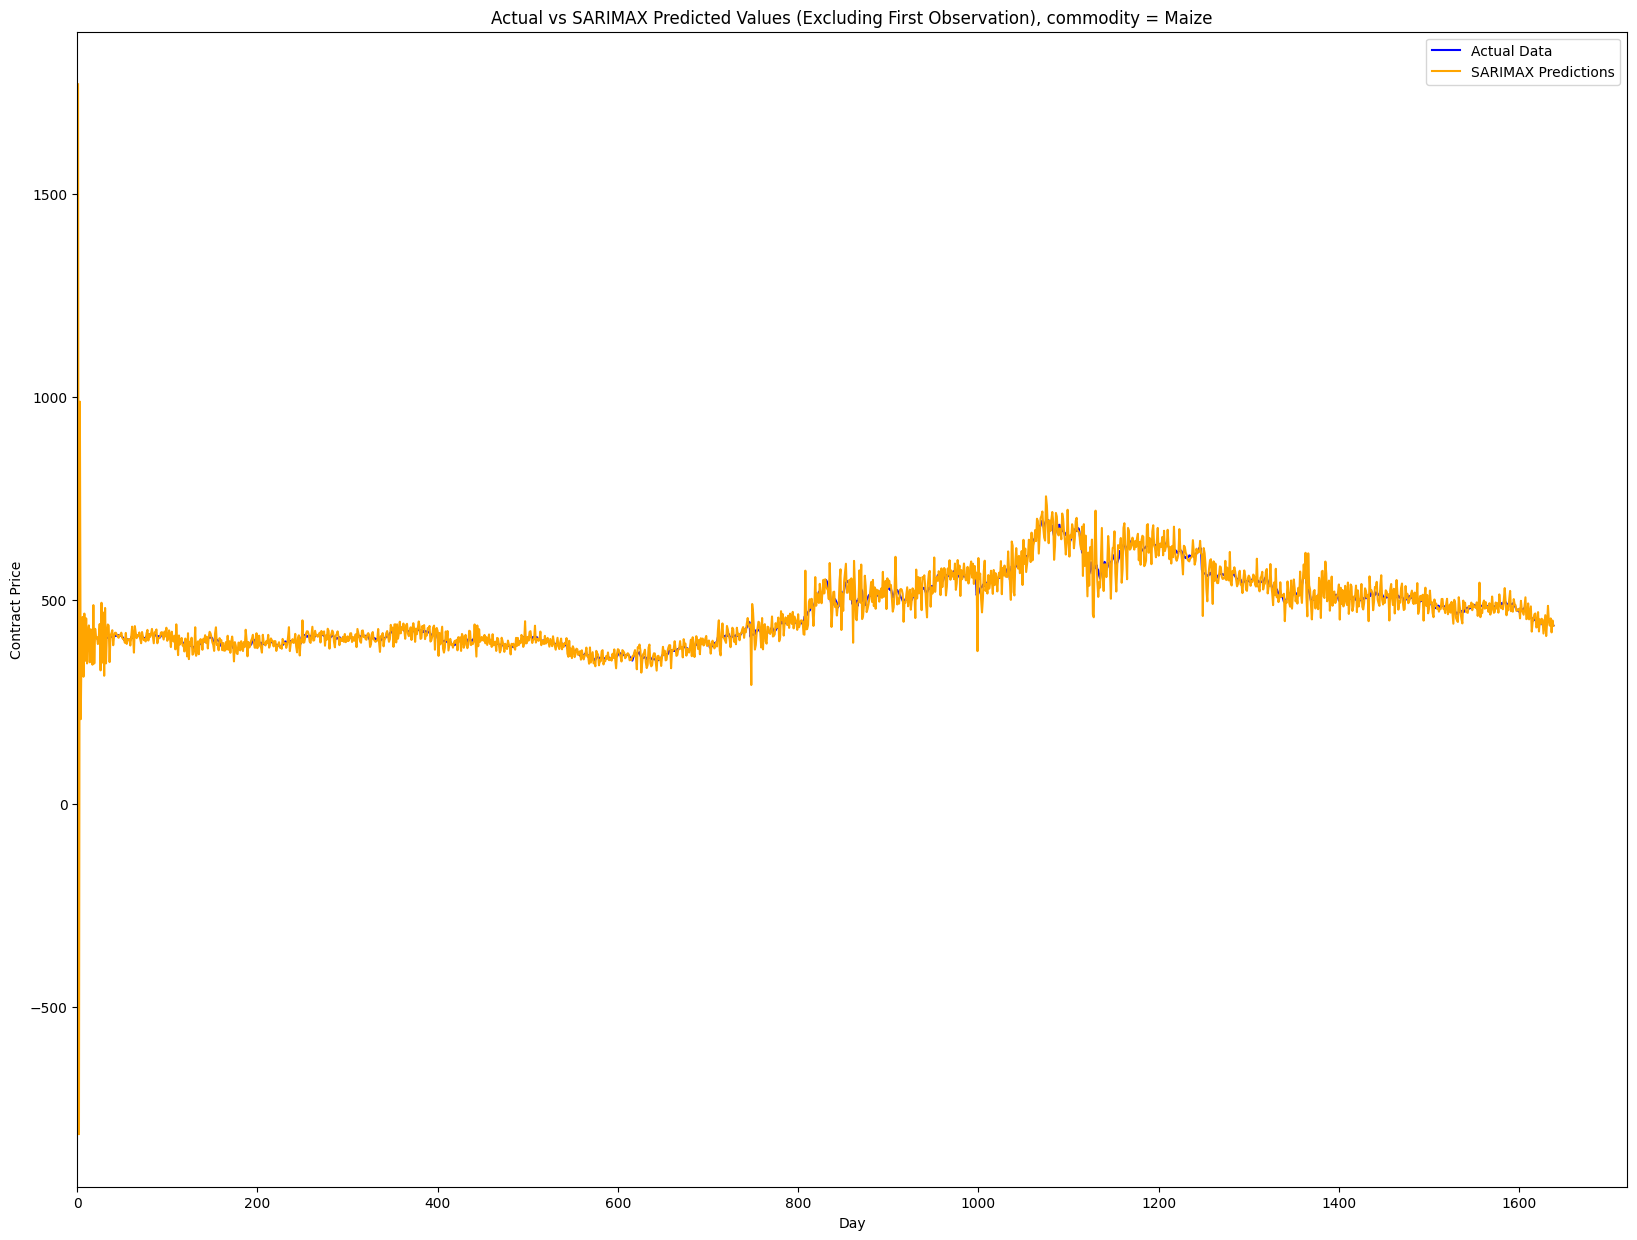

In [32]:
maize_all_sarimax = SARIMAX(commodities_datasets[0][Y_COLUMN], order=(7, 7, 0),seasonal_order=(2, 1, 0, 30))
maize_all_sarimax_fit = maize_all_sarimax.fit(disp=False)

start = 1  # Start from the second observation
end = len(commodities_datasets[0][Y_COLUMN]) - 1  # End index for predictions

maize_all_sarimax_fit_predictions = maize_all_sarimax_fit.predict(start=start, end=end)

# Slice the actual data to exclude the first observation
actual_data_without_first_maize = commodities_datasets[0][Y_COLUMN][1:]

plt.figure(figsize=(20, 15))
plt.plot(actual_data_without_first_maize, label='Actual Data', color='blue')

plt.plot(maize_all_sarimax_fit_predictions, label='SARIMAX Predictions', color='orange')

plt.xlabel('Day')
plt.ylabel('Contract Price')
plt.title(f'Actual vs SARIMAX Predicted Values (Excluding First Observation), commodity = {commodities[0]}')
plt.legend()
plt.xlim(0,)
plt.show()


In [33]:
training_rmse_maize = (((maize_all_sarimax_fit_predictions[:-len(test_datasets[0])] - actual_data_without_first_maize[:-len(test_datasets[0])]) ** 2).mean())**0.5
training_rmse_maize

59.23726236943016

In [34]:
test_rmse_maize = (((maize_all_sarimax_fit_predictions[-len(test_datasets[0]):] - actual_data_without_first_maize[-len(test_datasets[0]):]) ** 2).mean())**0.5
test_rmse_maize

22.906685354420333

### Wheat

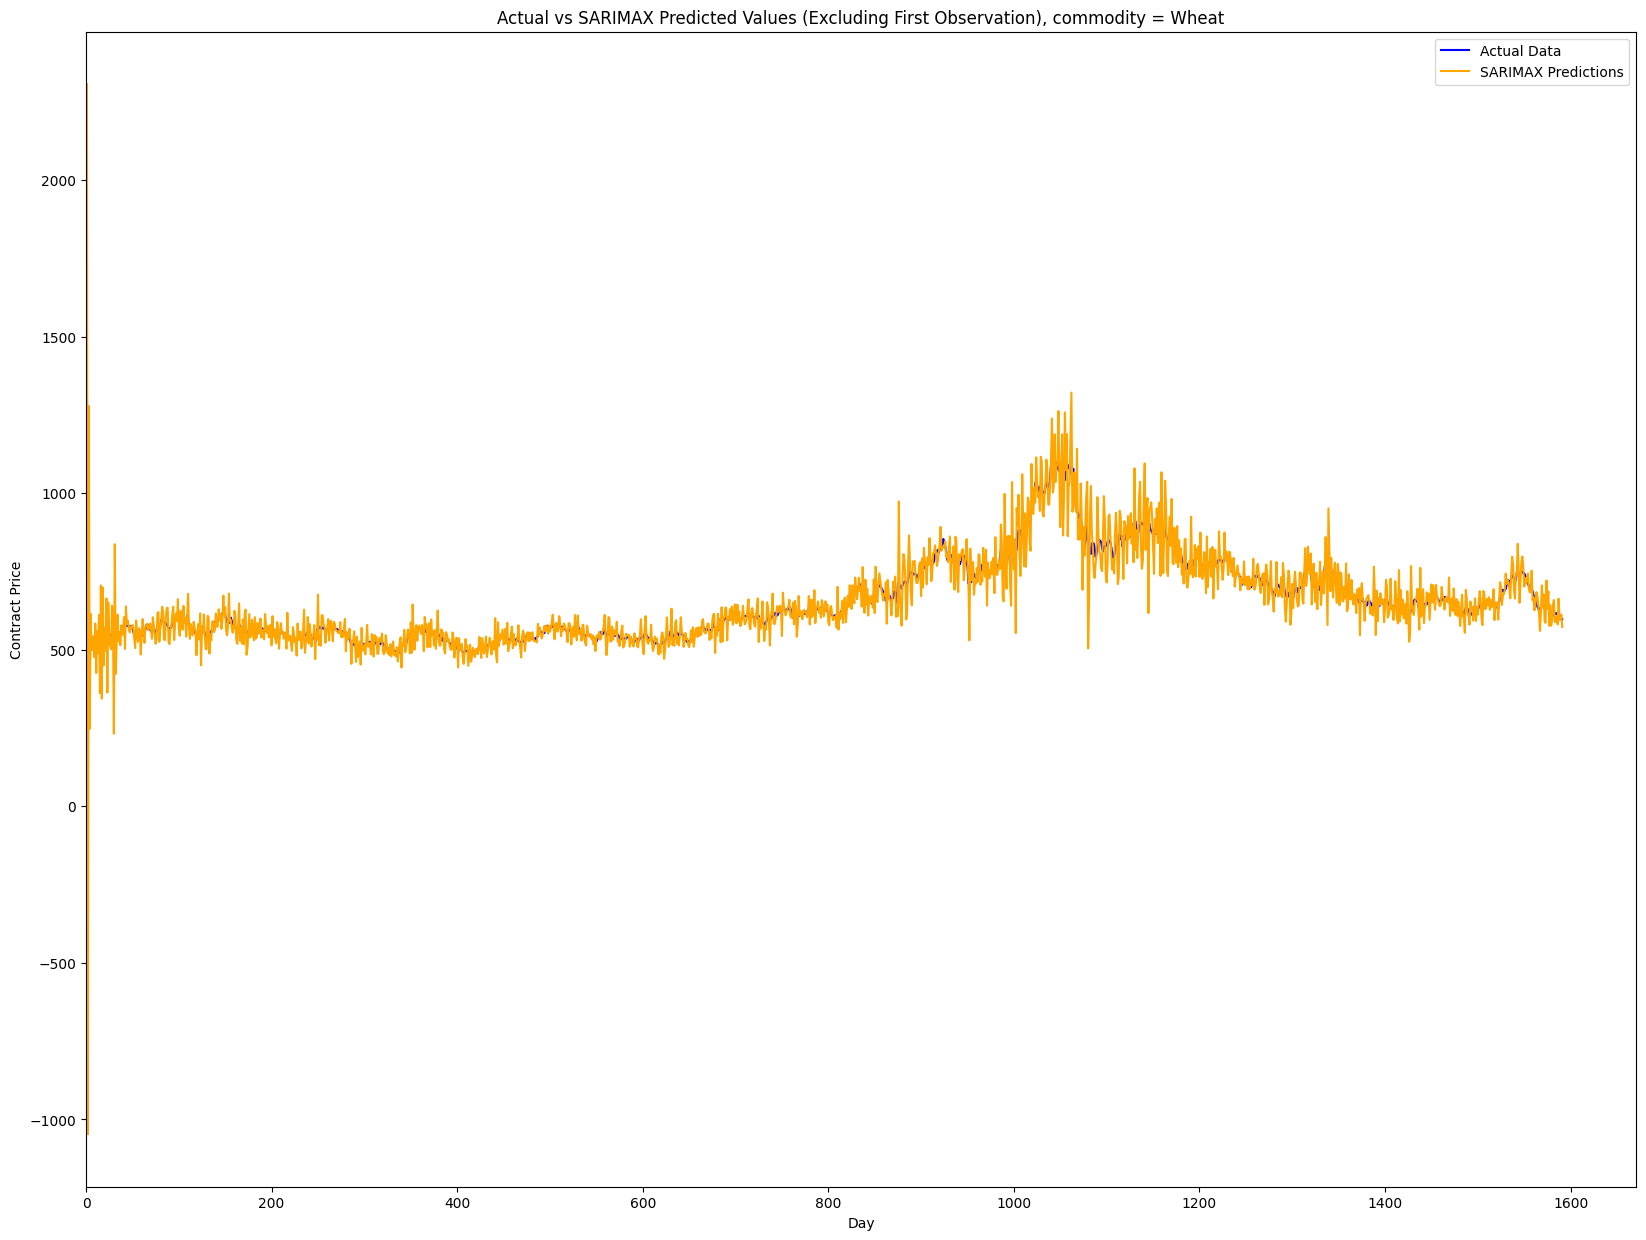

In [35]:
wheat_all_sarimax = SARIMAX(commodities_datasets[1][Y_COLUMN], order=(7, 7, 0),seasonal_order=(2, 1, 0, 30))
wheat_all_sarimax_fit = wheat_all_sarimax.fit(disp=False)
start = 1  # Start from the second observation
end = len(commodities_datasets[1][Y_COLUMN]) - 1  # End index for predictions

wheat_all_sarimax_fit_predictions = wheat_all_sarimax_fit.predict(start=start, end=end)

# Slice the actual data to exclude the first observation
actual_data_without_first_wheat = commodities_datasets[1][Y_COLUMN][1:]

plt.figure(figsize=(20, 15))
plt.plot(actual_data_without_first_wheat, label='Actual Data', color='blue')

plt.plot(wheat_all_sarimax_fit_predictions, label='SARIMAX Predictions', color='orange')

plt.xlabel('Day')
plt.ylabel('Contract Price')
plt.title(f'Actual vs SARIMAX Predicted Values (Excluding First Observation), commodity = {commodities[1]}')
plt.legend()
plt.xlim(0,)

plt.show()


In [36]:
training_rmse_wheat = (((wheat_all_sarimax_fit_predictions[:-len(test_datasets[1])] - actual_data_without_first_wheat[:-len(test_datasets[1])]) ** 2).mean())**0.5
training_rmse_wheat

89.04147760265141

In [37]:
test_rmse_wheat = (((wheat_all_sarimax_fit_predictions[-len(test_datasets[1]):] - actual_data_without_first_wheat[-len(test_datasets[1]):]) ** 2).mean())**0.5
test_rmse_wheat

45.42690372220985

### Oats

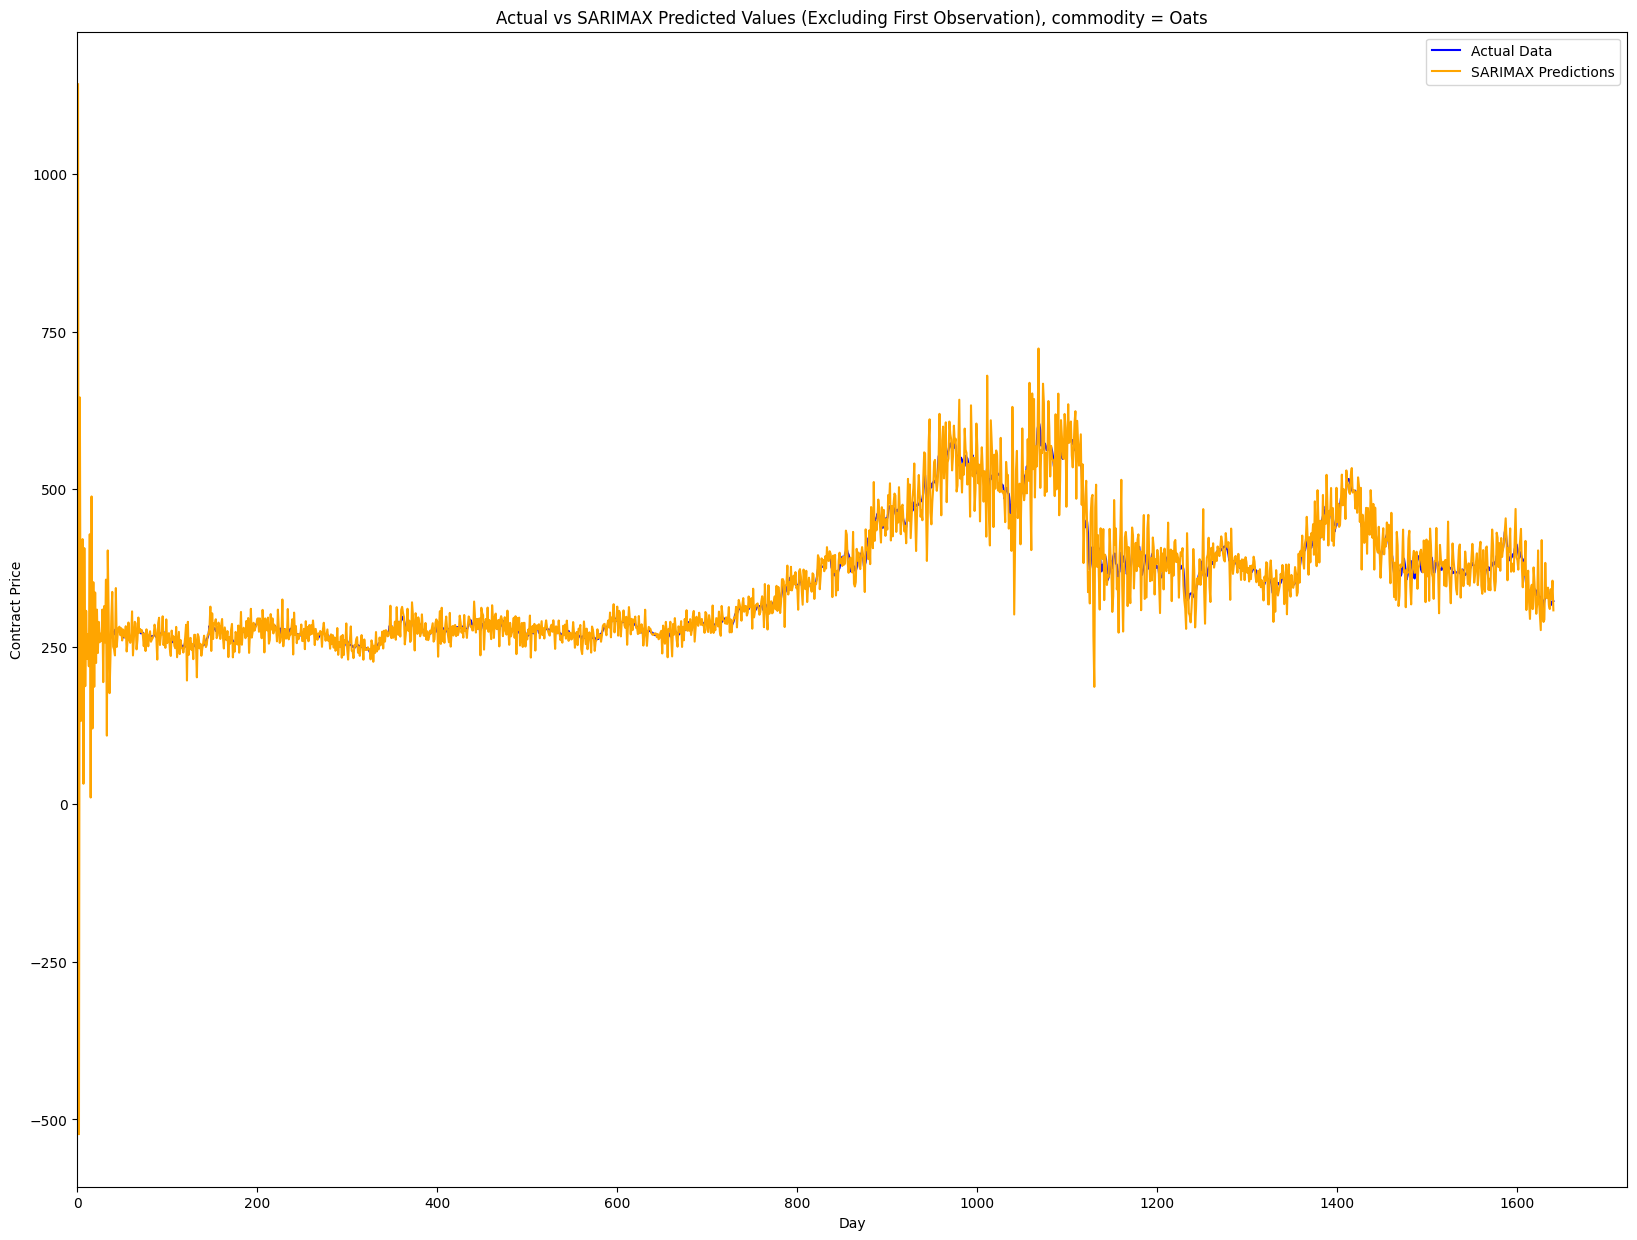

In [38]:
oats_all_sarimax = SARIMAX(commodities_datasets[2][Y_COLUMN], order=(7, 7, 0),seasonal_order=(2, 1, 0, 30))
oats_all_sarimax_fit = oats_all_sarimax.fit(disp=False)
start = 1  # Start from the second observation
end = len(commodities_datasets[2][Y_COLUMN]) - 1  # End index for predictions

oats_all_sarimax_fit_predictions = oats_all_sarimax_fit.predict(start=start, end=end)

# Slice the actual data to exclude the first observation
actual_data_without_first_oats = commodities_datasets[2][Y_COLUMN][1:]

plt.figure(figsize=(20, 15))
plt.plot(actual_data_without_first_oats, label='Actual Data', color='blue')

plt.plot(oats_all_sarimax_fit_predictions, label='SARIMAX Predictions', color='orange')

plt.xlabel('Day')
plt.ylabel('Contract Price')
plt.title(f'Actual vs SARIMAX Predicted Values (Excluding First Observation), commodity = {commodities[2]}')
plt.legend()
plt.xlim(0,)

plt.show()


In [39]:
training_rmse_oats = (((oats_all_sarimax_fit_predictions[:-len(test_datasets[2])] - actual_data_without_first_oats[:-len(test_datasets[2])]) ** 2).mean())**0.5
training_rmse_oats

48.47091690182667

In [40]:
test_rmse_oats = (((oats_all_sarimax_fit_predictions[-len(test_datasets[2]):] - actual_data_without_first_oats[-len(test_datasets[2]):]) ** 2).mean())**0.5
test_rmse_oats

29.35369454225994

### Soybeans

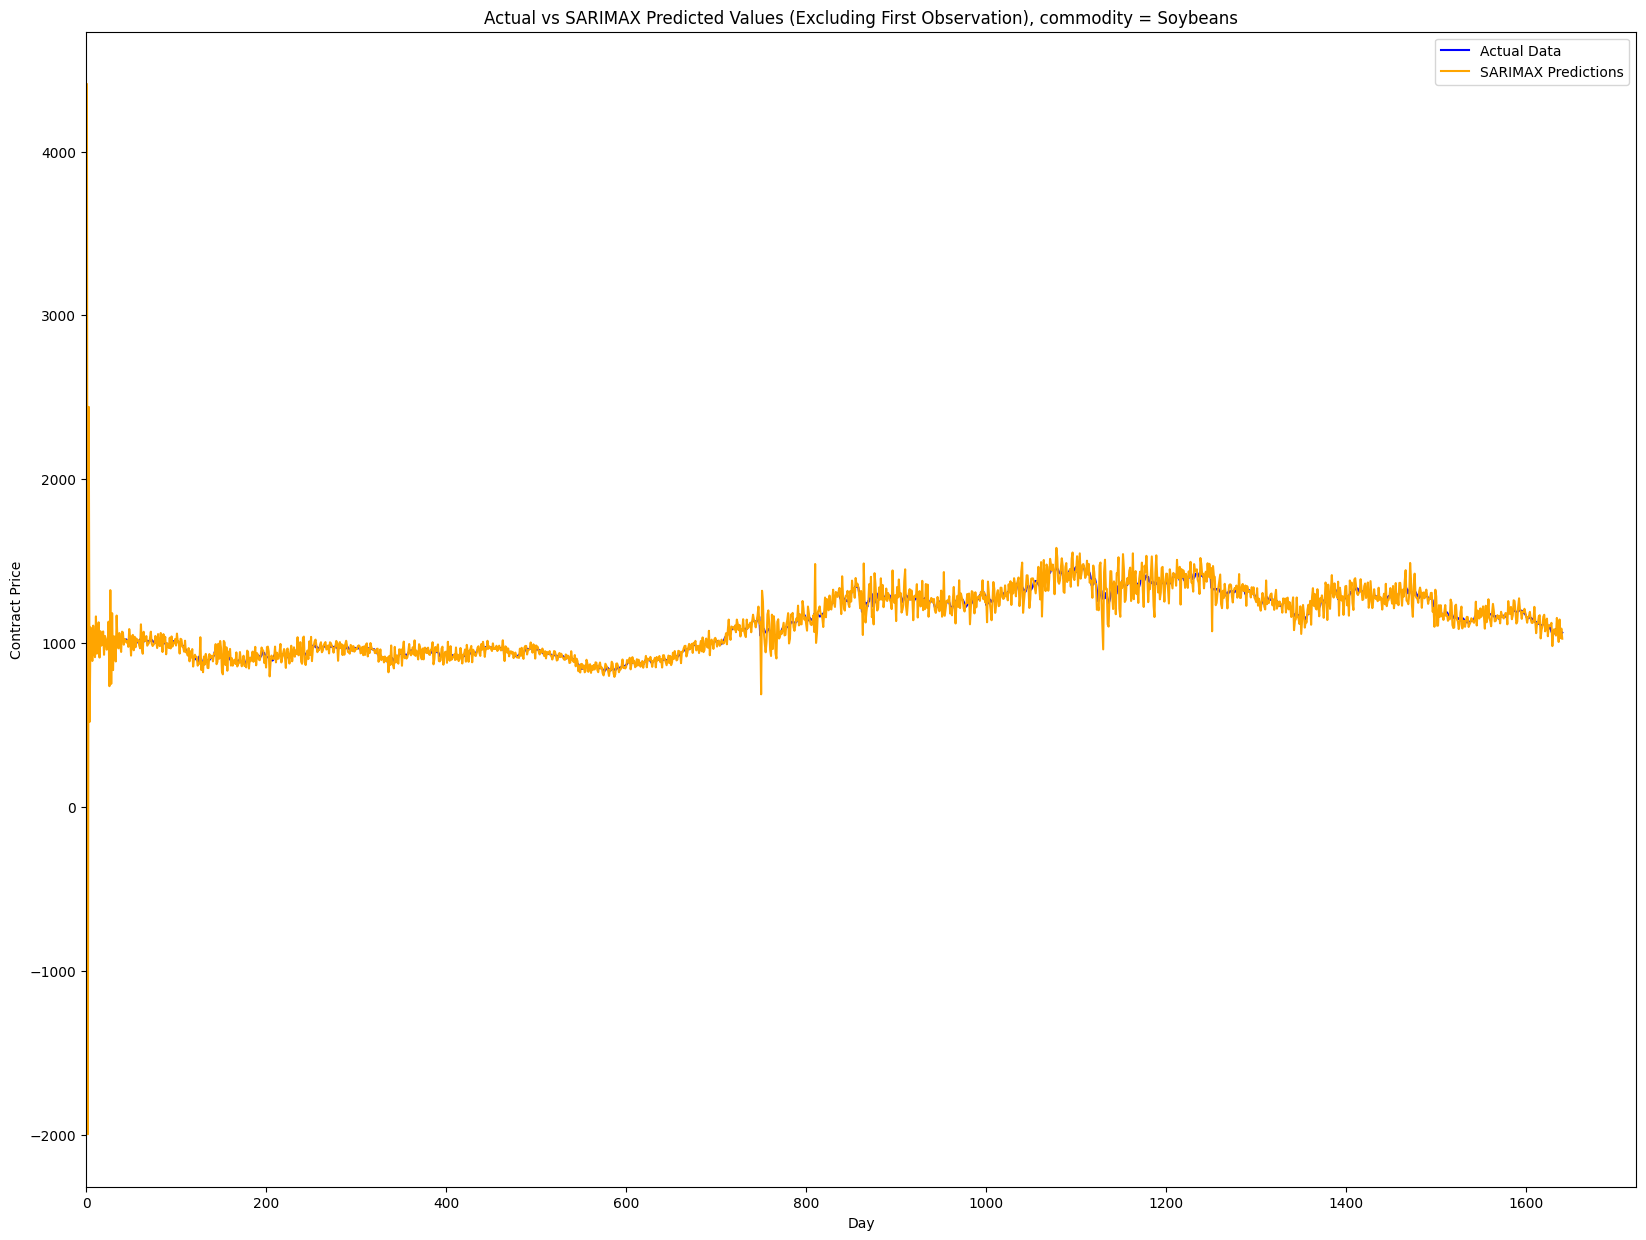

In [41]:
soybeans_all_sarimax = SARIMAX(commodities_datasets[3][Y_COLUMN], order=(7, 7, 0),seasonal_order=(2, 1, 0, 30))
soybeans_all_sarimax_fit = soybeans_all_sarimax.fit(disp=False)
start = 1  # Start from the second observation
end = len(commodities_datasets[3][Y_COLUMN]) - 1  # End index for predictions

soybeans_all_sarimax_fit_predictions = soybeans_all_sarimax_fit.predict(start=start, end=end)

# Slice the actual data to exclude the first observation
actual_data_without_first_soybeans = commodities_datasets[3][Y_COLUMN][1:]

plt.figure(figsize=(20, 15))
plt.plot(actual_data_without_first_soybeans, label='Actual Data', color='blue')

plt.plot(soybeans_all_sarimax_fit_predictions, label='SARIMAX Predictions', color='orange')

plt.xlabel('Day')
plt.ylabel('Contract Price')
plt.title(f'Actual vs SARIMAX Predicted Values (Excluding First Observation), commodity = {commodities[3]}')
plt.legend()
plt.xlim(0,)

plt.show()


In [42]:
training_rmse_soybeans = (((soybeans_all_sarimax_fit_predictions[:-len(test_datasets[3])] - actual_data_without_first_soybeans[:-len(test_datasets[3])]) ** 2).mean())**0.5
training_rmse_soybeans

144.9513873113348

In [43]:
test_rmse_soybeans = (((soybeans_all_sarimax_fit_predictions[-len(test_datasets[3]):] - actual_data_without_first_soybeans[-len(test_datasets[3]):]) ** 2).mean())**0.5
test_rmse_soybeans

50.48242102372589

### Comparison of all RMSE losses, across all commodities (train and test)

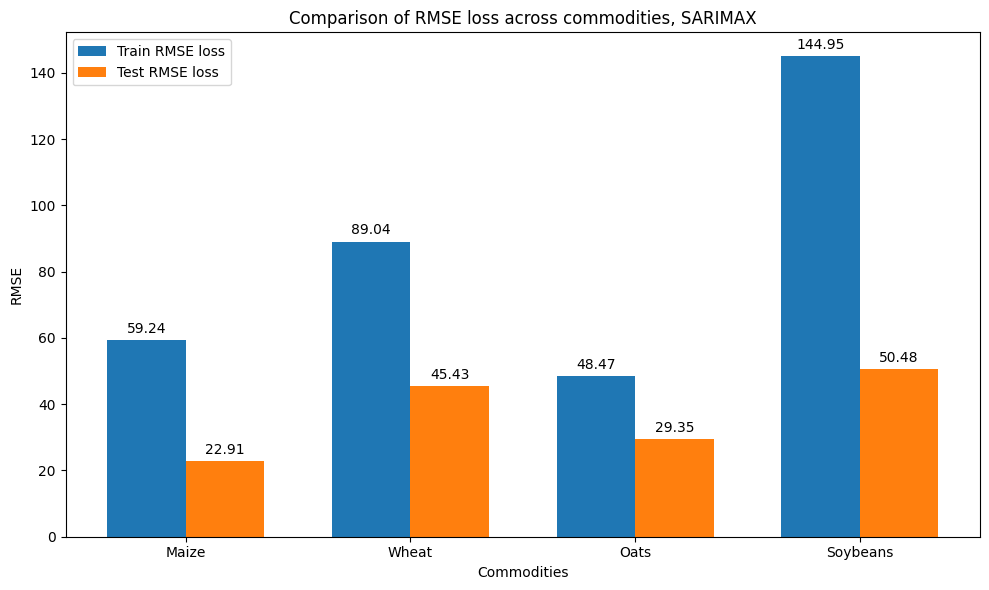

In [44]:
# RMSE values for each commodity: train and test losses
rmse_train = [training_rmse_maize, training_rmse_wheat, training_rmse_oats, training_rmse_soybeans]  # Example RMSE for train losses (4 commodities)
rmse_test = [test_rmse_maize, test_rmse_wheat, test_rmse_oats, test_rmse_soybeans]  # Example RMSE for test losses (4 commodities)

n_commodities = len(commodities)
ind = np.arange(n_commodities)  # the x locations for the commodities
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
train_bars = ax.bar(ind - width/2, rmse_train, width, label='Train RMSE loss')
test_bars = ax.bar(ind + width/2, rmse_test, width, label='Test RMSE loss')

ax.set_xlabel('Commodities')
ax.set_ylabel('RMSE')
ax.set_title('Comparison of RMSE loss across commodities, SARIMAX')
ax.set_xticks(ind)
ax.set_xticklabels(commodities)
ax.legend()

# Function to add labels above the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(train_bars)
add_labels(test_bars)
plt.tight_layout()
plt.show()


--------------------------

## Summarization

The results above are notable because, for each commodity type, the best combination of SARIMA parameters was the same. This led us to consider whether we should investigate the reciprocal influence of the different commodities on one another. It is highly likely that they are correlated in some way (as can also be seen in the decomposition graphs). Furthermore, it is clear that contracts with different deadlines for the same commodity are correlated.

We believe it might be interesting to explore these possible correlations. However, due to the success of the SARIMA models, we will set this aside for now as an interesting future direction to explore.

